In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 
sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
import warnings
warnings.filterwarnings("ignore")




# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


from tqdm import tqdm


# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations
pd.set_option("display.max_columns", None)


In [2]:
df_min=pd.read_csv("../../datos/datos1/datos_nulos_minmax.csv", index_col=0).reset_index(drop=True)


In [3]:
df_min["rooms"]=df_min["rooms"].astype("O")
df_min["bathrooms"]=df_min["bathrooms"].astype("O")

In [4]:
df_min.head(2)

price propertyType  exterior rooms bathrooms province  \
0  750.0         flat      True     1         1   Madrid   
1  750.0         flat      True     2         1   Madrid   

                 municipality status newDevelopment floor       district  \
0                      Madrid   good          False     3      Hortaleza   
1  San Sebastián de los Reyes   good          False    bj  Centro Urbano   

  hasLift parkingSpace  size_MinMax  distance_MinMax  
0    True  desconocido     0.310078         0.114738  
1   False  desconocido     0.387597         0.267209

Primero identificamos los outliers en univariados

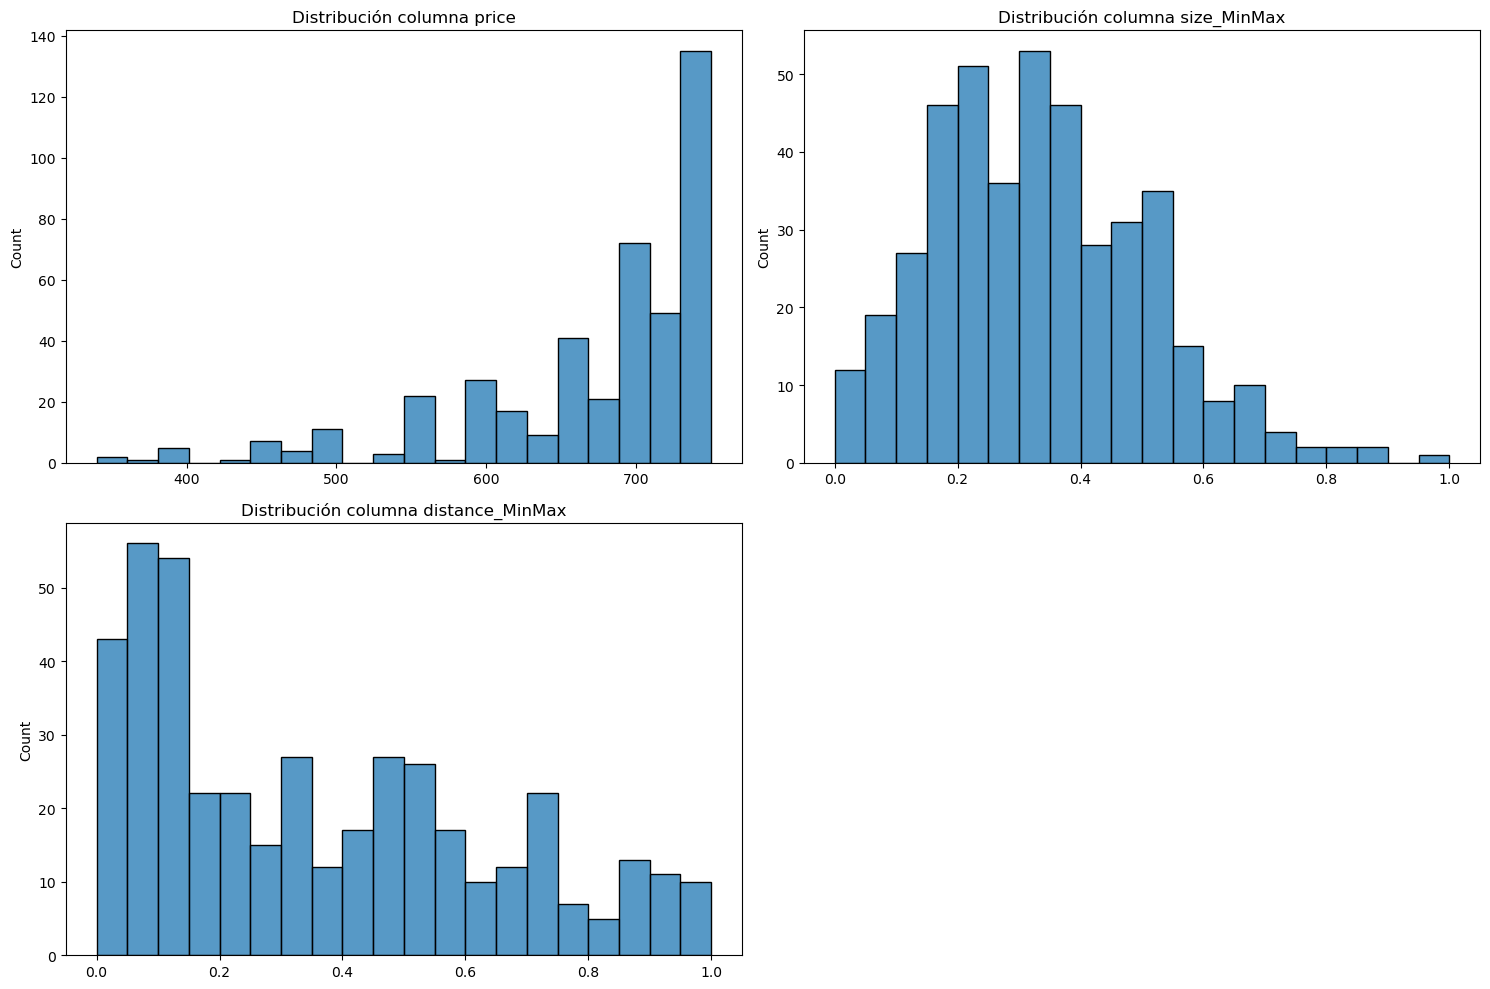

In [5]:
f.plot_outliers_univariados(df_min, "h", (15,10))

Recuerdo la distribución de las numéricas ya seleccionadas mediante la metodología de escalador min max

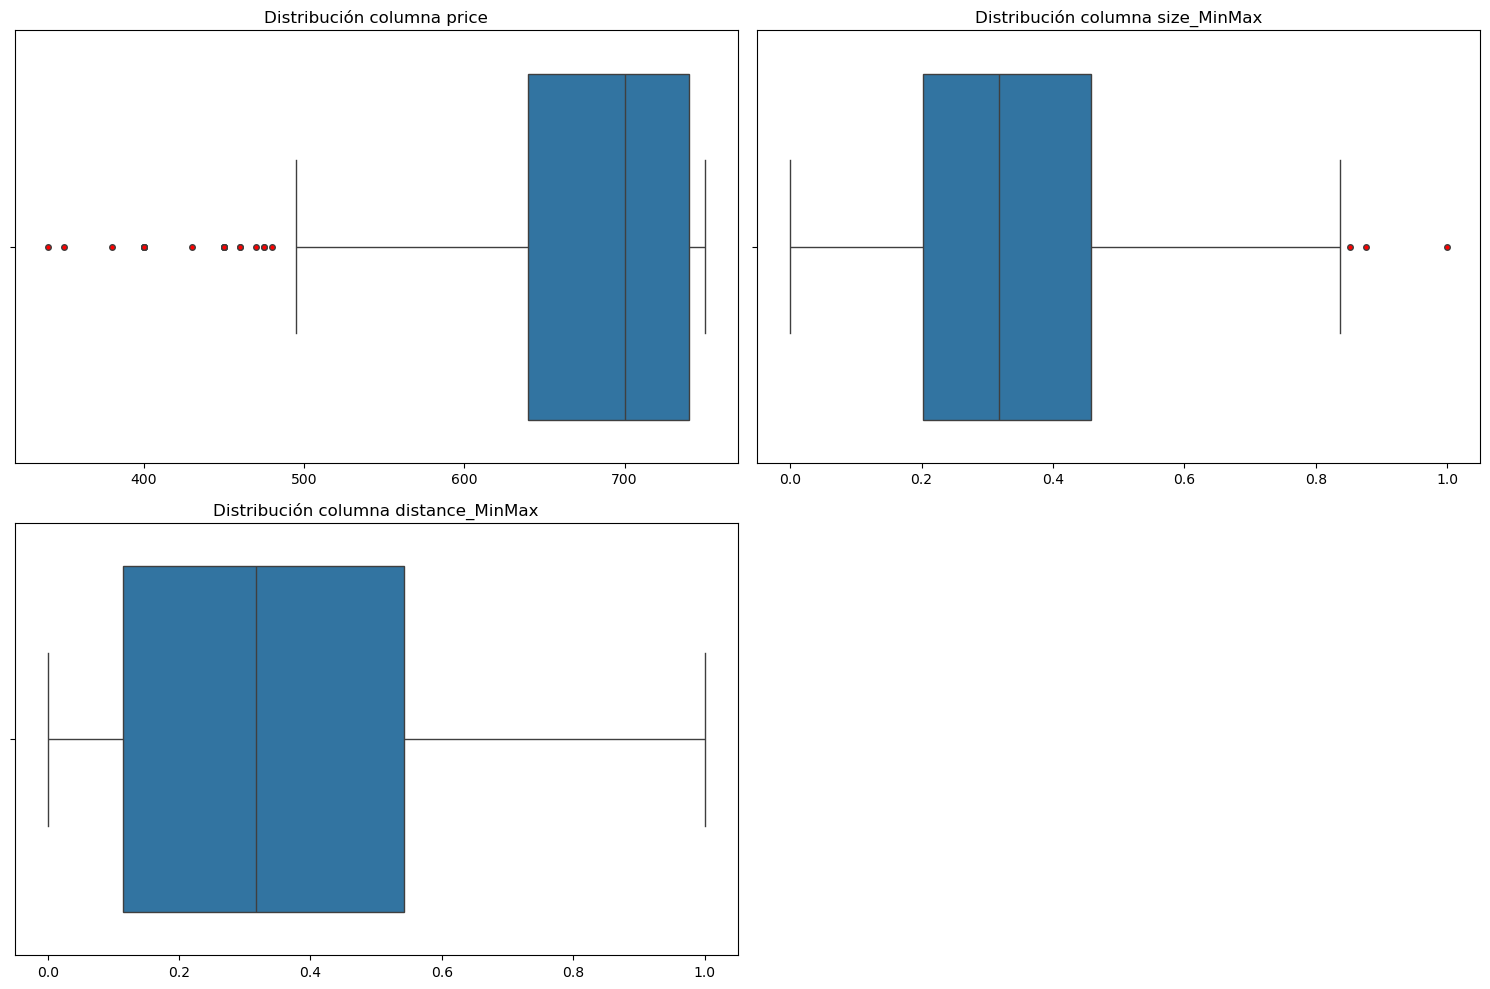

In [6]:
f.plot_outliers_univariados(df_min, "b", (15,10))

Observo los outliers de las numéricas ya seleccionadas mediante la metodología de escalador min max

In [7]:
num=df_min.select_dtypes(include=np.number)
num.describe().T

count        mean        std    min         25%         50%  \
price            428.0  672.546729  84.625889  340.0  640.000000  700.000000   
size_MinMax      428.0    0.335652   0.173686    0.0    0.201550    0.317829   
distance_MinMax  428.0    0.358102   0.280799    0.0    0.113968    0.316702   

                        75%    max  
price            740.000000  750.0  
size_MinMax        0.457364    1.0  
distance_MinMax    0.542395    1.0

In [8]:
dicc_zsc=f.identificar_outliers_zscore(df_min)

La cantidad de outliers para la PRICE es de 8 outliers
La cantidad de outliers para la SIZE_MINMAX es de 2 outliers
La cantidad de outliers para la DISTANCE_MINMAX es de 0 outliers


Dado que no tienen una distribución normal ninguna de ellas, no utilizaré el Z-Score ya que el porcentaje de fallo será demasiado alto. Por ello opto por el IQR

In [9]:
dicc_iqr=f.identificar_outliers_iqr(df_min)

La columna PRICE tiene 20 outliers
La columna SIZE_MINMAX tiene 3 outliers
La columna DISTANCE_MINMAX tiene 0 outliers


Nos fijamos en que parece haber muy pocos Outliers

In [10]:
dicc_iqr["price"].head(2)

price propertyType  exterior rooms bathrooms province  \
2  400.0    penthouse      True     2         2   Madrid   
3  450.0         flat     False     2         1  Afueras   

            municipality status newDevelopment floor     district hasLift  \
2  Villamanrique de Tajo   good          False     2  desconocido   False   
3                  Recas   good          False     2  desconocido    True   

  parkingSpace  size_MinMax  distance_MinMax  
2  desconocido     0.364341         0.918341  
3         True     0.534884         0.786845

In [11]:
dicc_iqr["size_MinMax"].head(2)

price propertyType  exterior rooms bathrooms province municipality status  \
62  750.0       chalet     False     4         1  Afueras   Marchamalo   good   
68  720.0         flat     False     3         2   Madrid        Pinto   good   

   newDevelopment        floor                 district      hasLift  \
62          False  desconocido              desconocido  desconocido   
68          False            1  San José - Buenos Aires         True   

   parkingSpace  size_MinMax  distance_MinMax  
62  desconocido     0.852713         0.847897  
68         True     0.875969         0.322586

Observamos como el número de outliers es muy bajo por lo general y parecen estar muy separados entre ellos. Esto me lleva a pensar que un IFO podría ser la mejor opción. Sin embargo, vamos a comprobarlo. 

In [12]:
contaminacion= [0.01, 0.05, 0.1]
estimadores = [100,400,1000, 2000] 
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_min[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_min[["price","size_MinMax","distance_MinMax"]]) 

In [13]:
df_min["outliers_ifo_0.01_100"].value_counts(normalize=True)    #Esto nos muetsra como se acerca mucho al 1% de outliers por el nivel de contaminación ser 0.01

outliers_ifo_0.01_100
 1    0.988318
-1    0.011682
Name: proportion, dtype: float64

In [14]:
df_min.head()

price propertyType  exterior rooms bathrooms province  \
0  750.0         flat      True     1         1   Madrid   
1  750.0         flat      True     2         1   Madrid   
2  400.0    penthouse      True     2         2   Madrid   
3  450.0         flat     False     2         1  Afueras   
4  450.0         flat      True     2         1  Afueras   

                 municipality status newDevelopment floor       district  \
0                      Madrid   good          False     3      Hortaleza   
1  San Sebastián de los Reyes   good          False    bj  Centro Urbano   
2       Villamanrique de Tajo   good          False     2    desconocido   
3                       Recas   good          False     2    desconocido   
4         Cedillo del Condado   good          False     1    desconocido   

  hasLift parkingSpace  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
0    True  desconocido     0.310078         0.114738                      1   
1   False  desconocido     0.387597         0.267209                      1   
2   False  desconocido     0.364341         0.918341                      1   
3    True         True     0.534884         0.786845                      1   
4   False  desconocido     0.310078         0.637036                      1   

   outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
0                      1                       1                       1   
1                      1                       1                       1   
2                      1                       1                       1   
3                      1                       1                       1   
4                      1                       1                       1   

   outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
0                       1                     1                     1   
1                       1                     1                     1   
2                      -1                    -1                    -1   
3                       1                    -1                    -1   
4                       1                    -1                     1   

   outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
0                      1                      1  
1                      1                      1  
2                     -1                     -1  
3                     -1                     -1  
4                      1                      1

In [15]:
columnas_hue=df_min.filter(like="outliers")

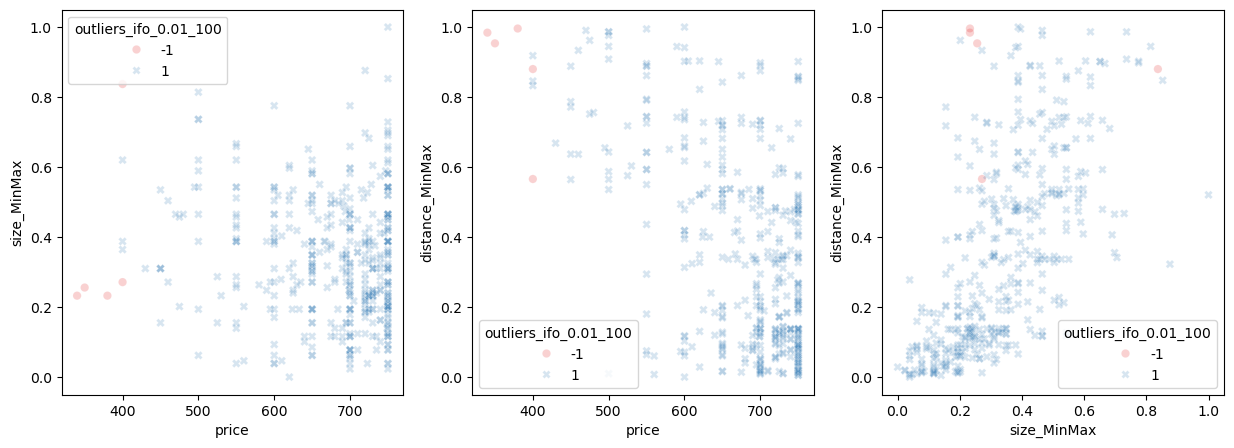

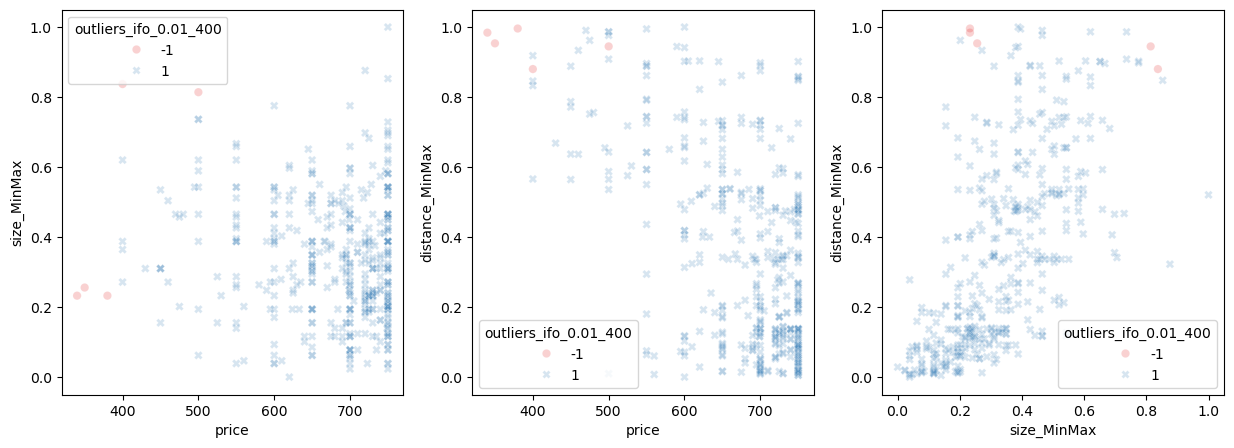

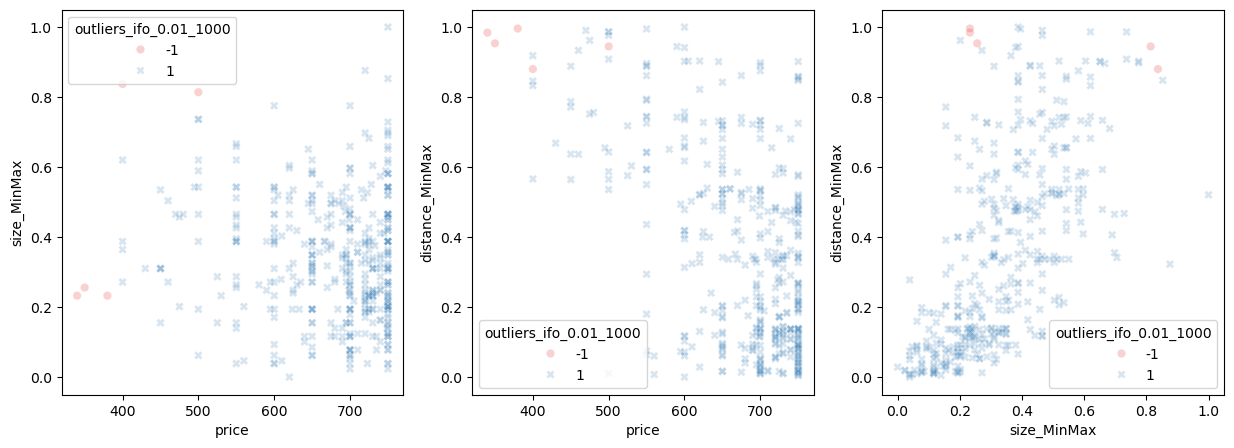

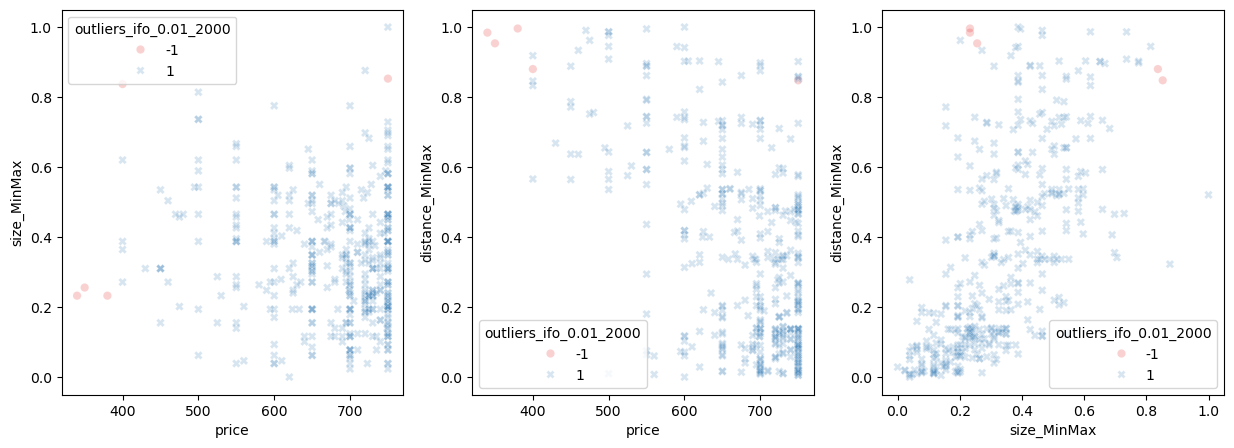

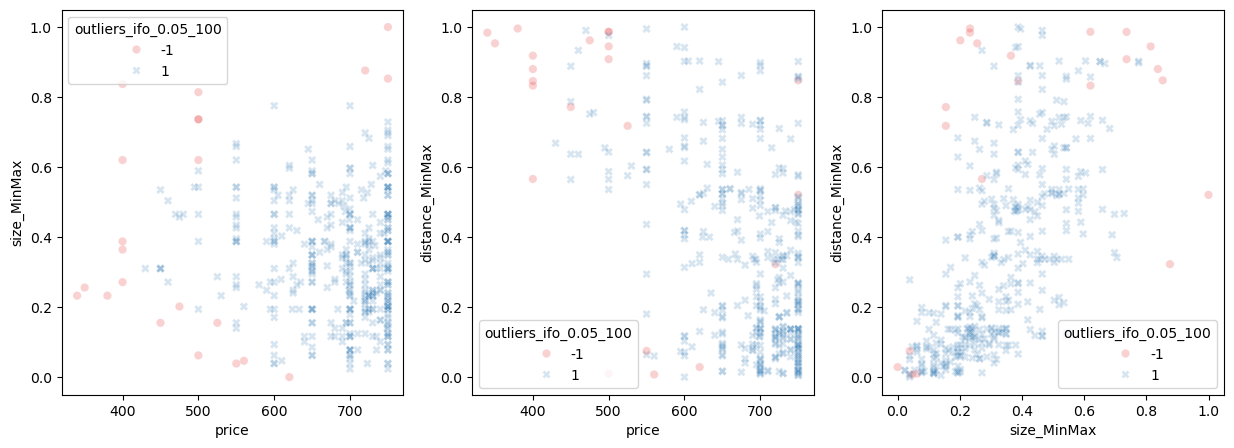

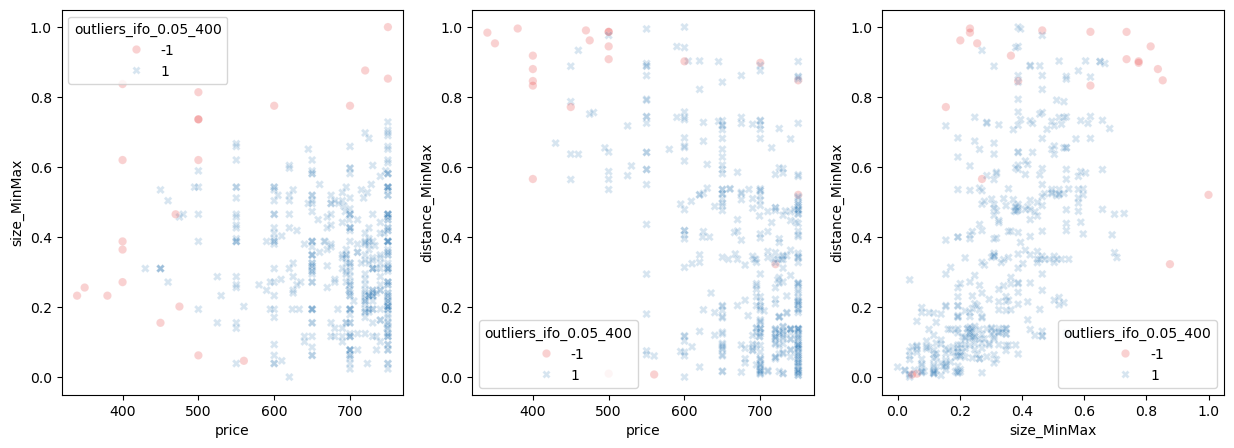

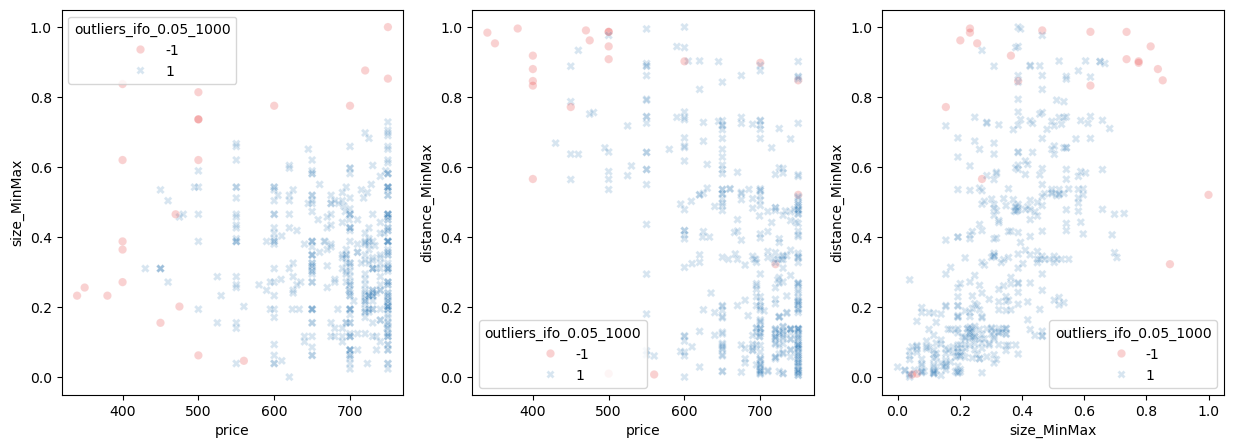

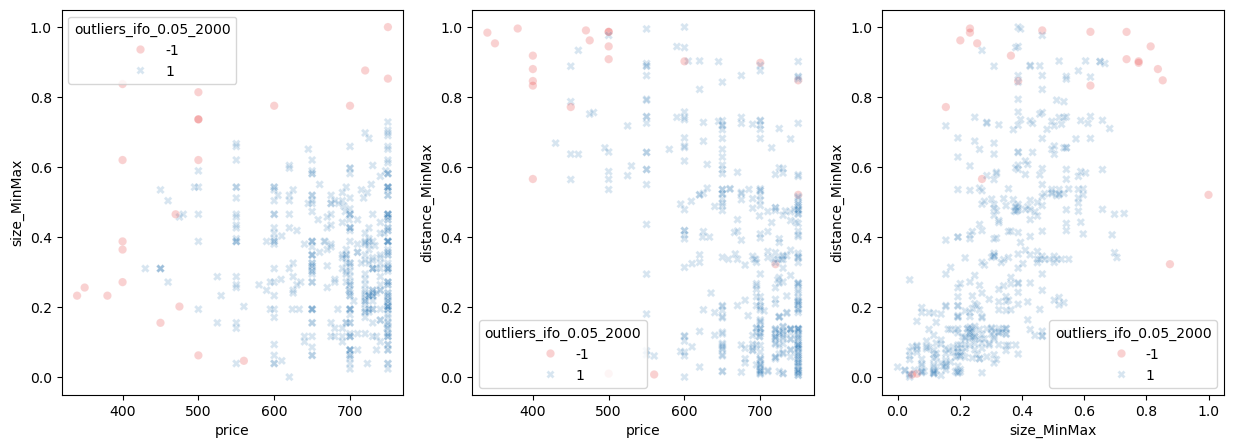

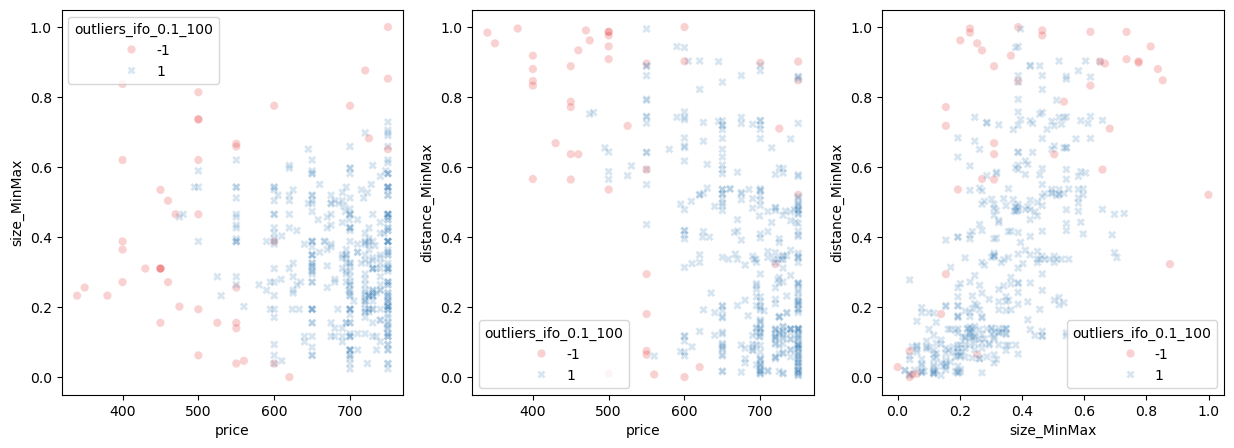

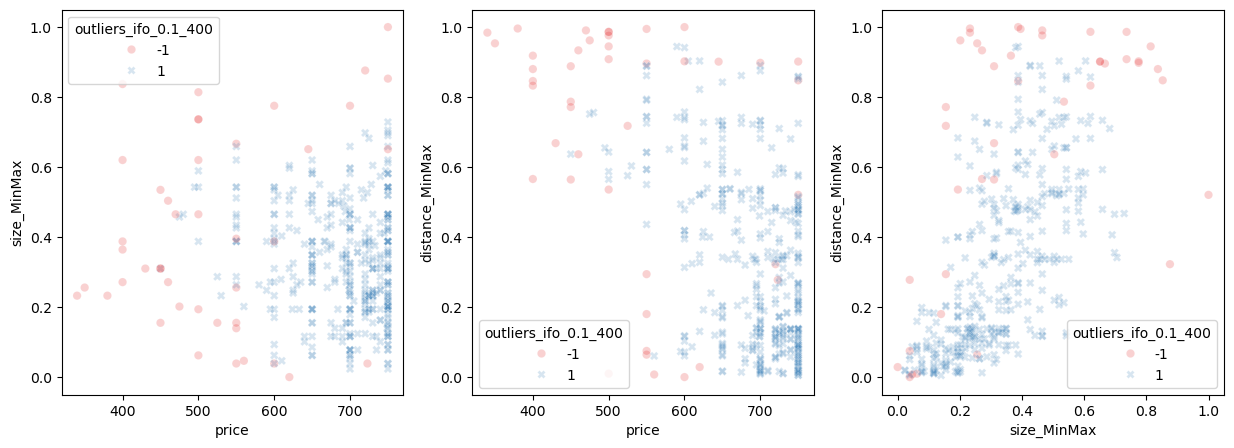

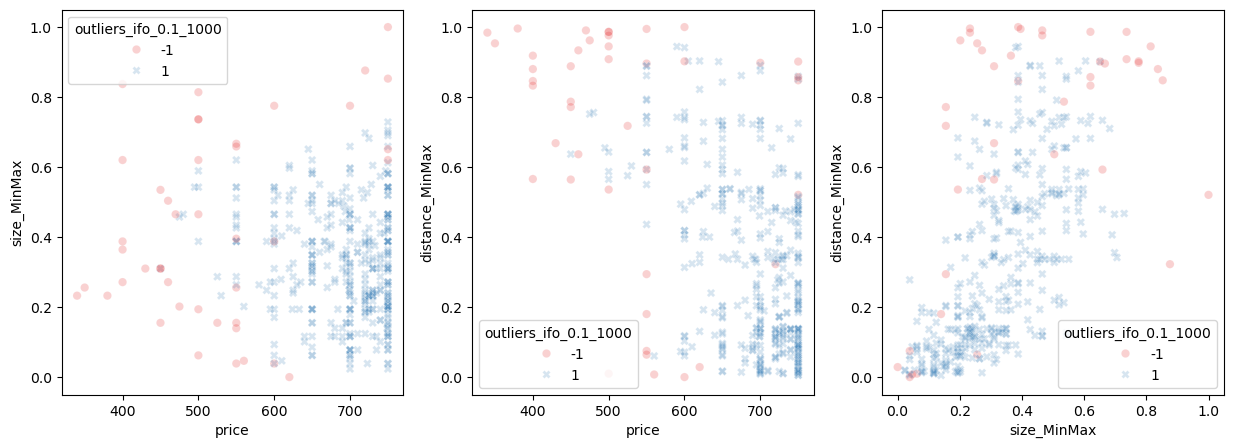

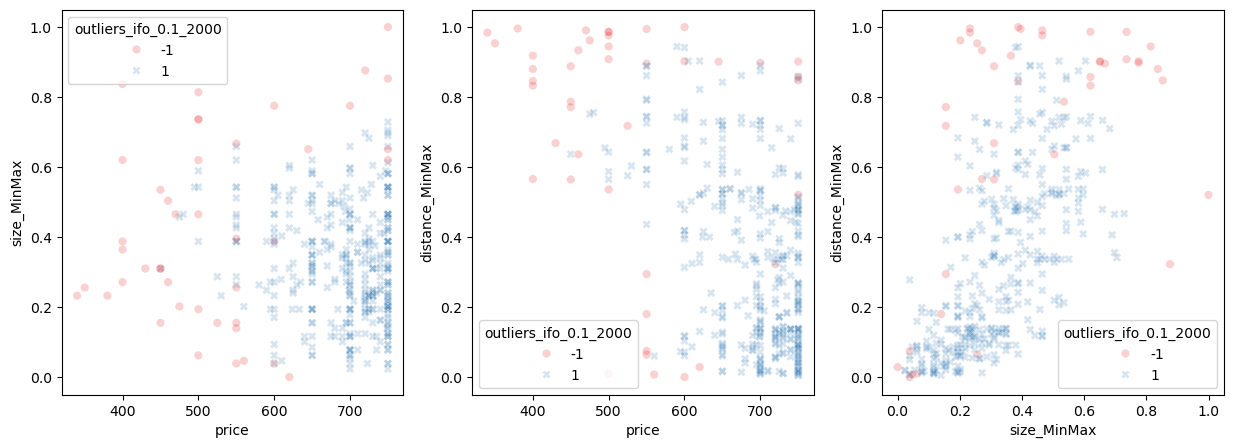

In [16]:
combinaciones_visual=list(combinations(["price","size_MinMax","distance_MinMax"], 2))

for out in columnas_hue:


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
    axes=axes.flat
    for indice, tupla in enumerate(combinaciones_visual):
        sns.scatterplot(x=tupla[0], y=tupla[1], ax= axes[indice], data=df_min, hue= out, palette= "Set1", alpha= 0.2, style= out)

Observamos como a mayor número de arboles los outliers se van agrupando más.  
Además según vamos siendo más estrictos con el nivel de contaminación, más sentido tiene la interpretación. 
Podemos observar como el IFO nos muestrá que por lo general los precios bajos son considerados outliers.

In [17]:
df_min.head()

price propertyType  exterior rooms bathrooms province  \
0  750.0         flat      True     1         1   Madrid   
1  750.0         flat      True     2         1   Madrid   
2  400.0    penthouse      True     2         2   Madrid   
3  450.0         flat     False     2         1  Afueras   
4  450.0         flat      True     2         1  Afueras   

                 municipality status newDevelopment floor       district  \
0                      Madrid   good          False     3      Hortaleza   
1  San Sebastián de los Reyes   good          False    bj  Centro Urbano   
2       Villamanrique de Tajo   good          False     2    desconocido   
3                       Recas   good          False     2    desconocido   
4         Cedillo del Condado   good          False     1    desconocido   

  hasLift parkingSpace  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
0    True  desconocido     0.310078         0.114738                      1   
1   False  desconocido     0.387597         0.267209                      1   
2   False  desconocido     0.364341         0.918341                      1   
3    True         True     0.534884         0.786845                      1   
4   False  desconocido     0.310078         0.637036                      1   

   outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
0                      1                       1                       1   
1                      1                       1                       1   
2                      1                       1                       1   
3                      1                       1                       1   
4                      1                       1                       1   

   outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
0                       1                     1                     1   
1                       1                     1                     1   
2                      -1                    -1                    -1   
3                       1                    -1                    -1   
4                       1                    -1                     1   

   outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
0                      1                      1  
1                      1                      1  
2                     -1                     -1  
3                     -1                     -1  
4                      1                      1


A pesar de que teóricamente el IFO por las carcaterísticas de los datos parece ser la mejor opción y tras haber observado que marca outliers en los precios ma´s bajo. Pasamos ahora a identificar los outliers con la metodología LOF.

Para poder comparar más fácil voy a sacar IFO y LOF juntos.

100%|██████████| 21/21 [00:03<00:00,  6.43it/s]


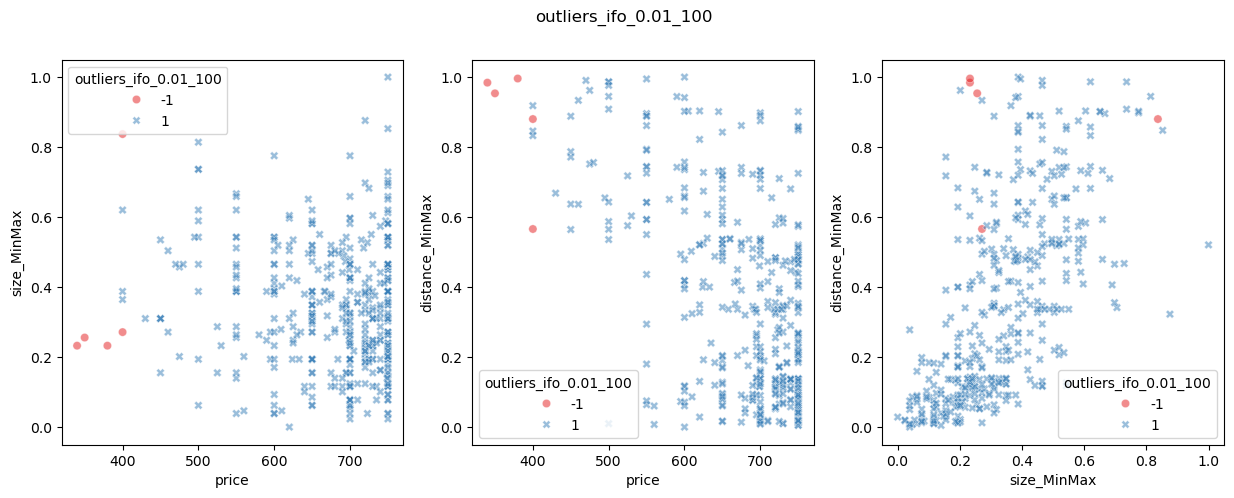

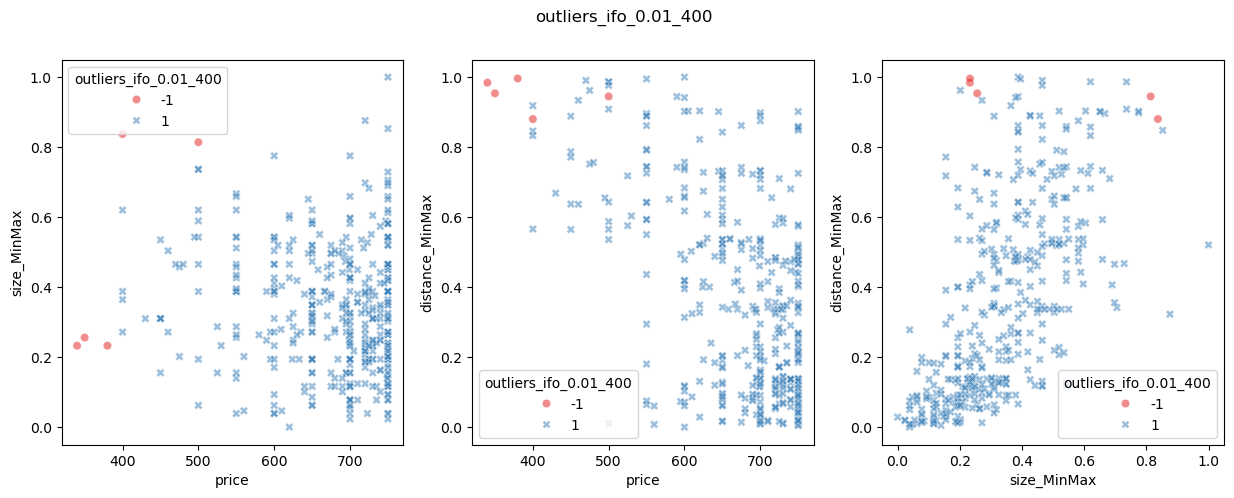

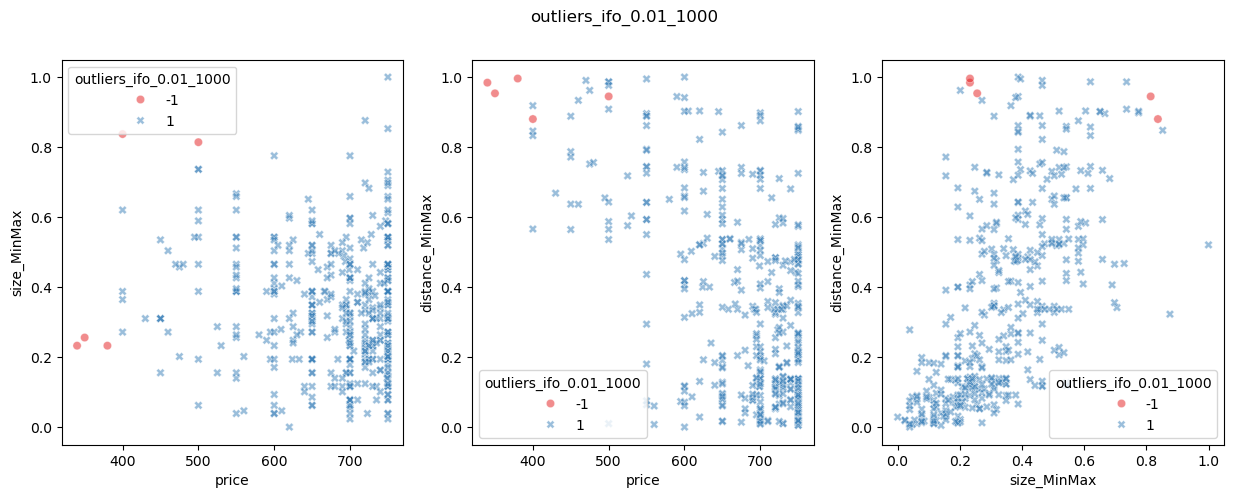

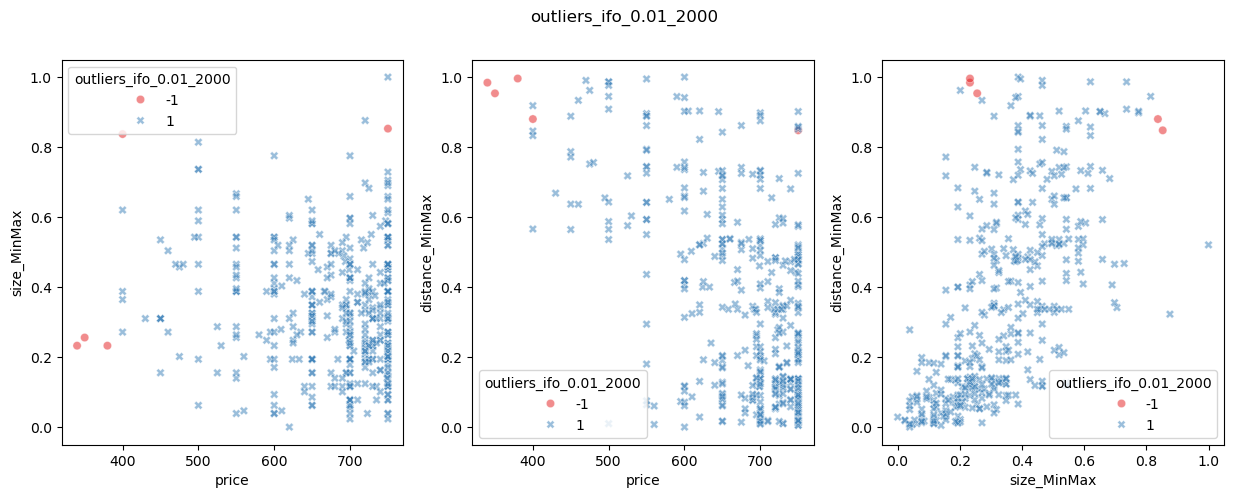

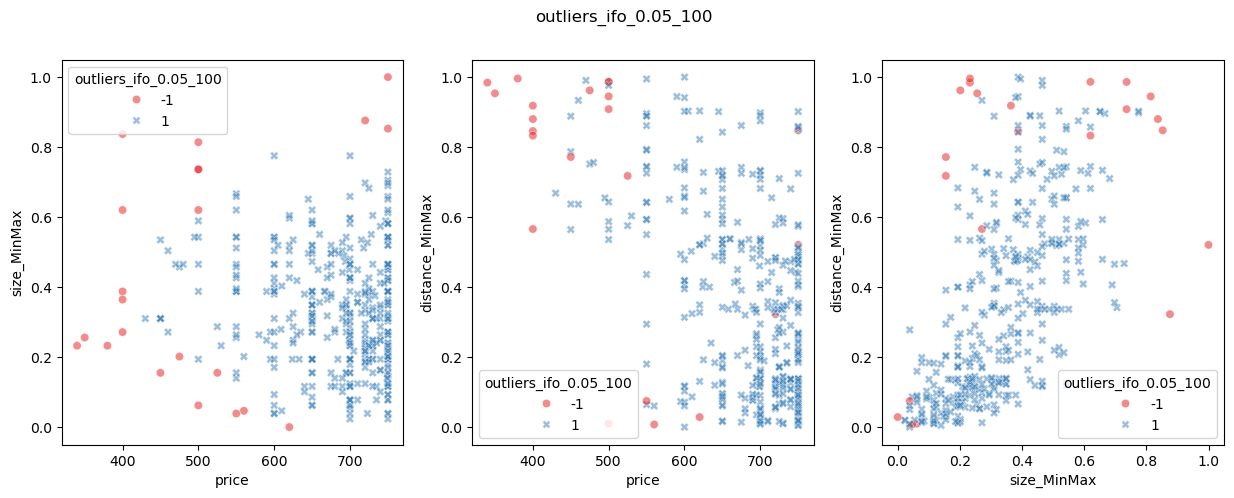

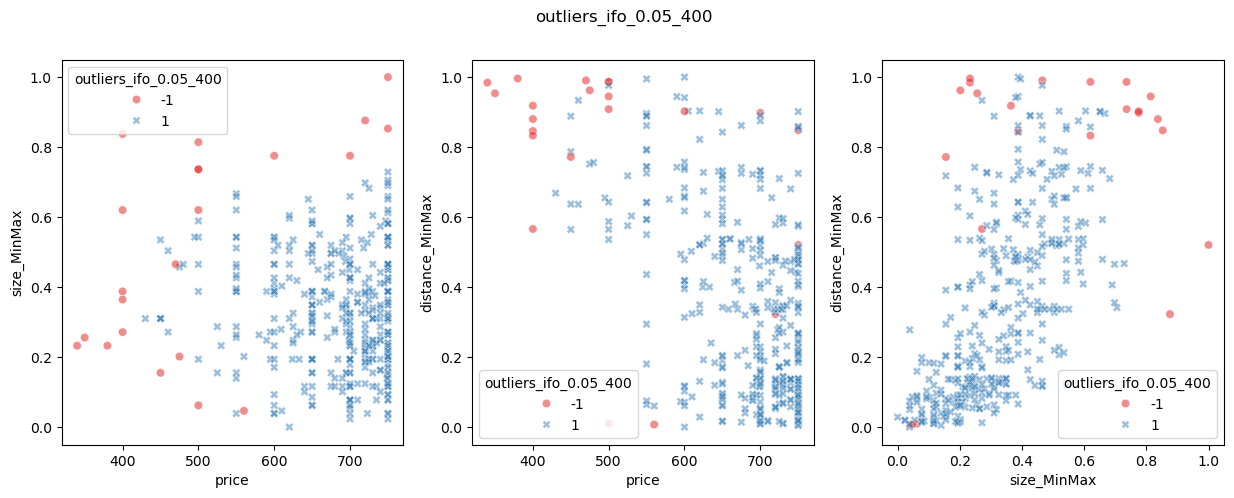

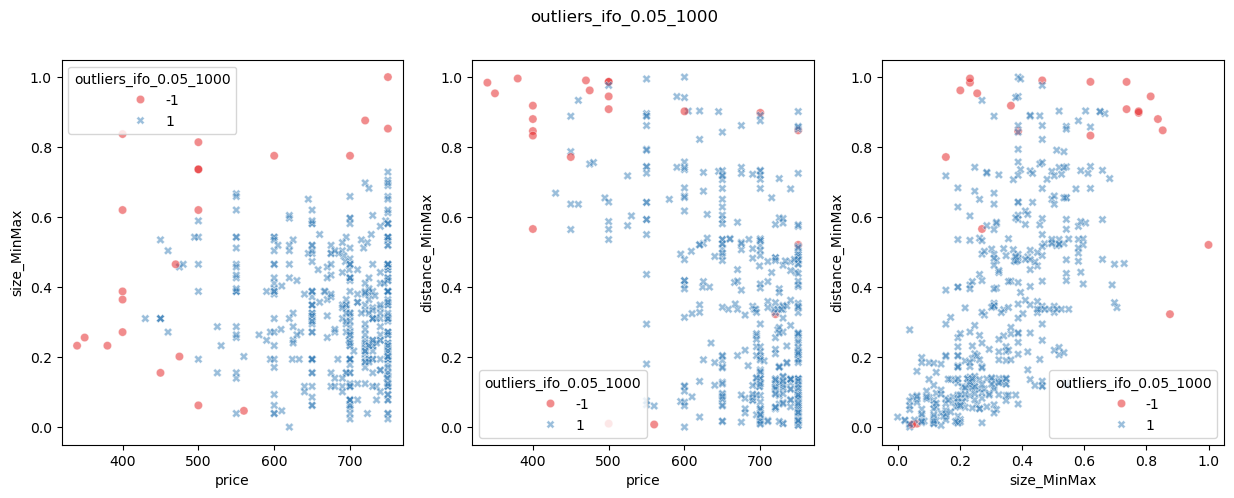

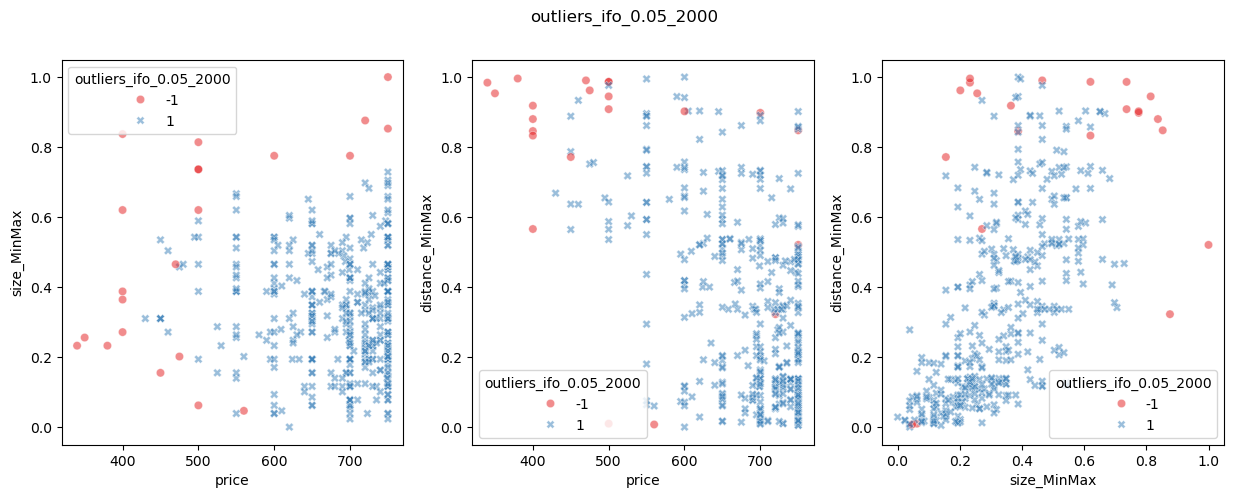

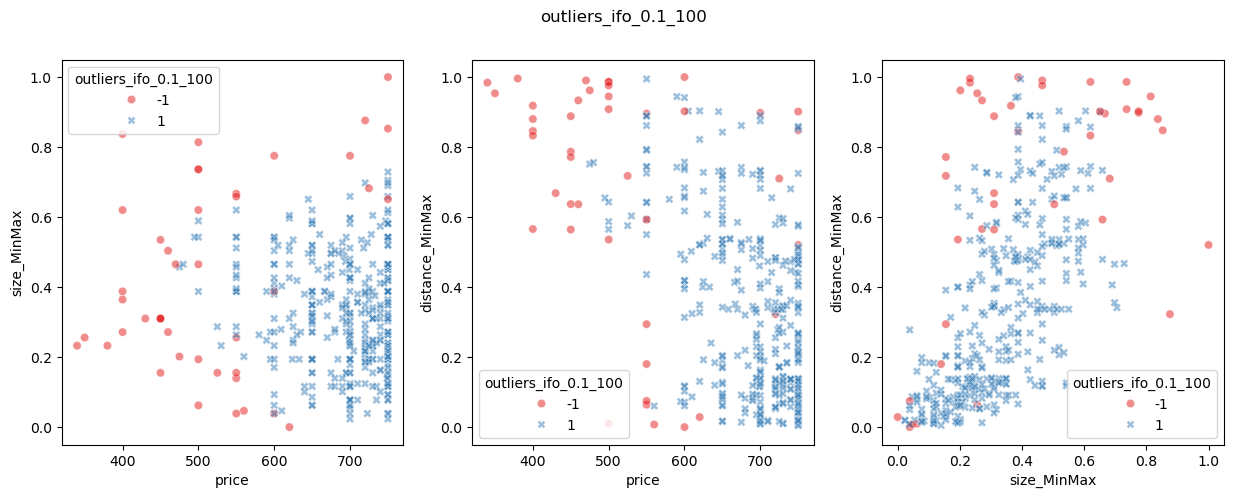

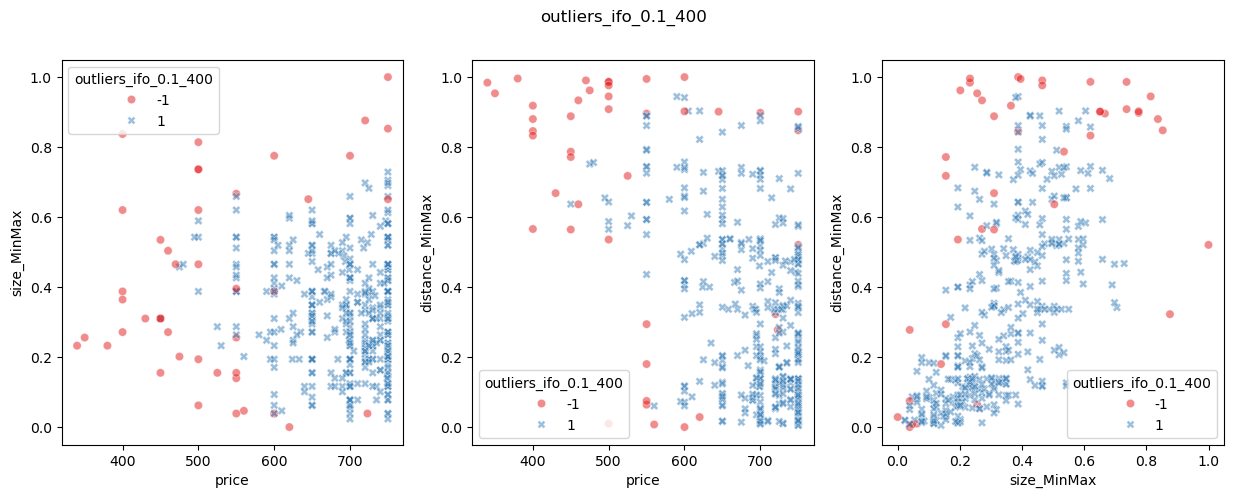

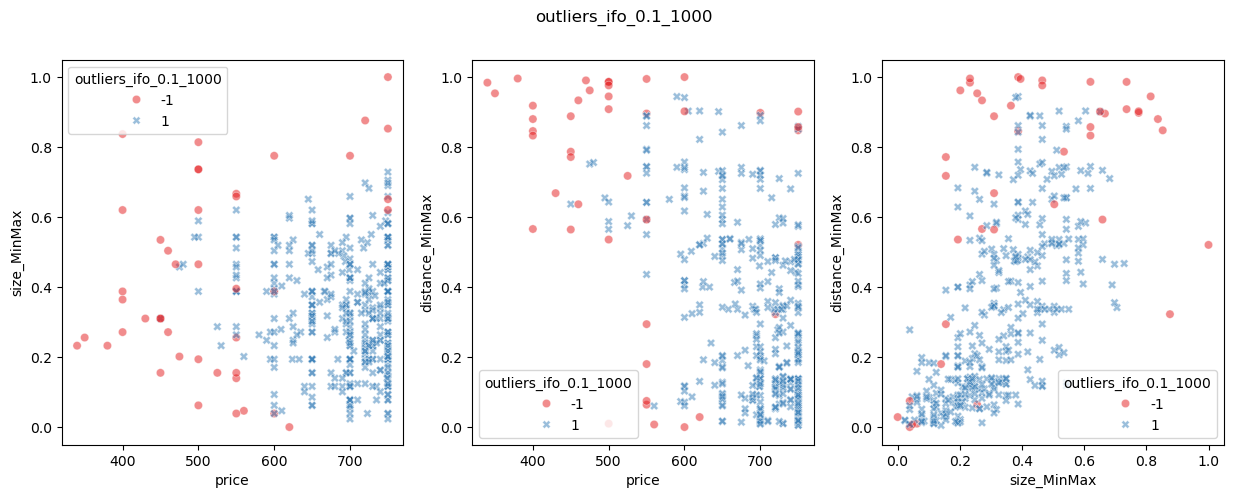

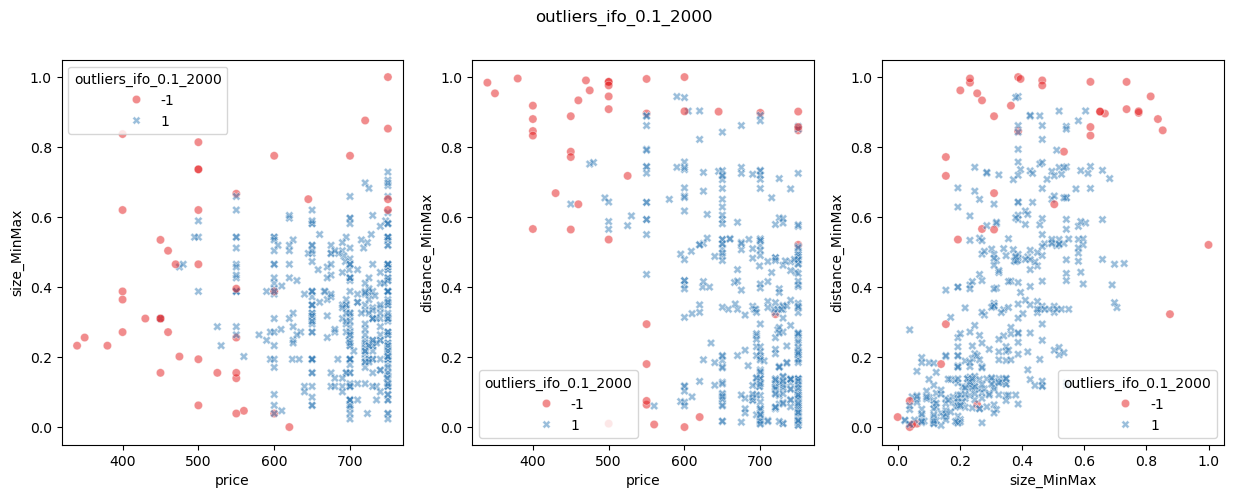

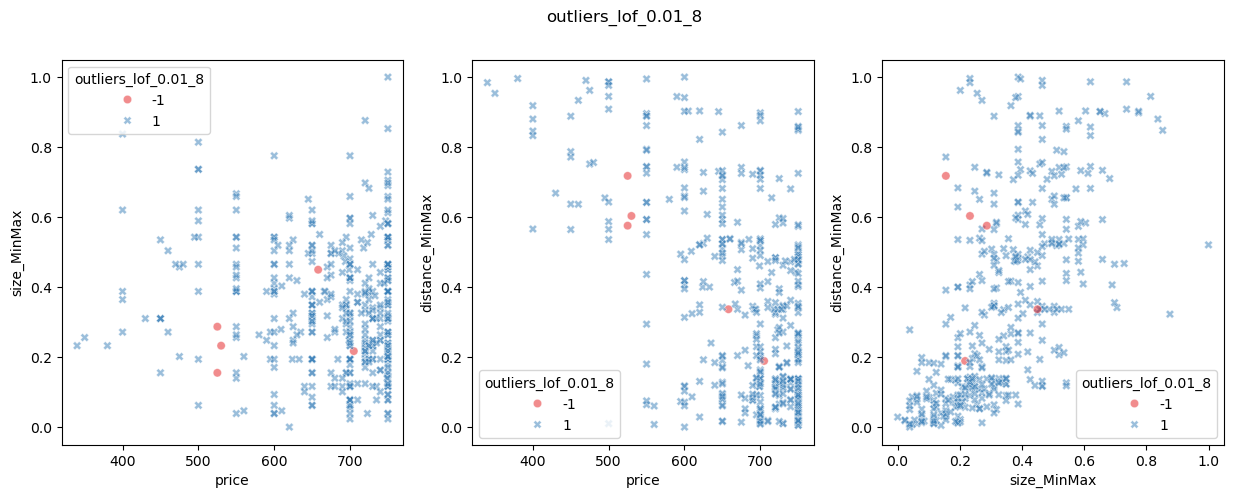

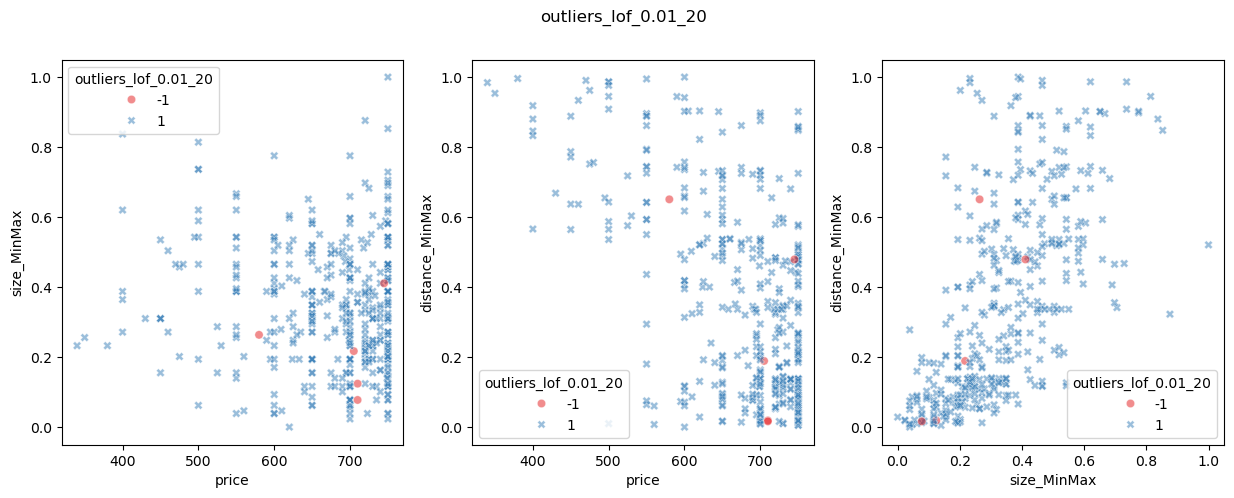

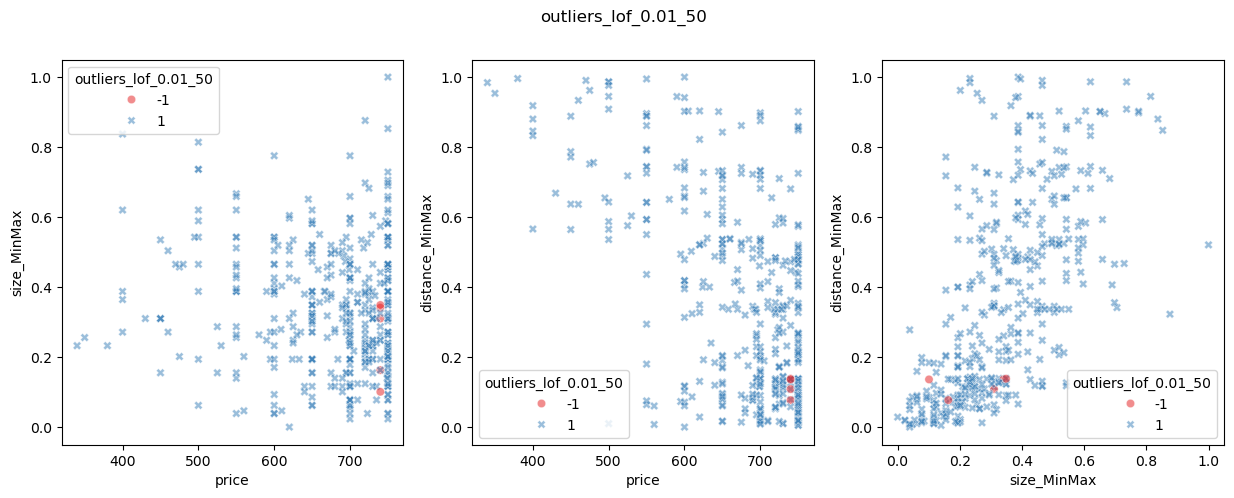

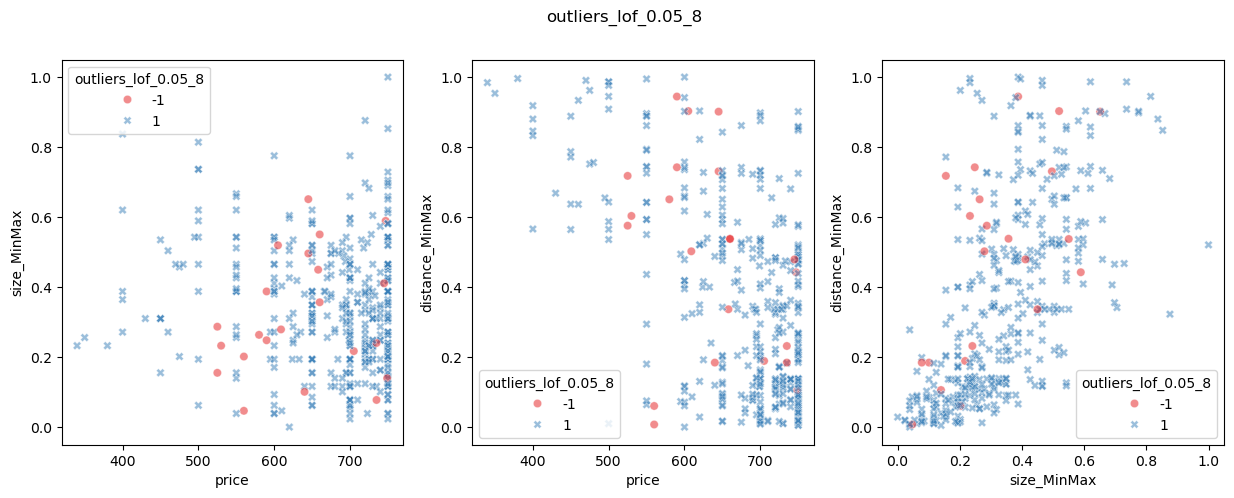

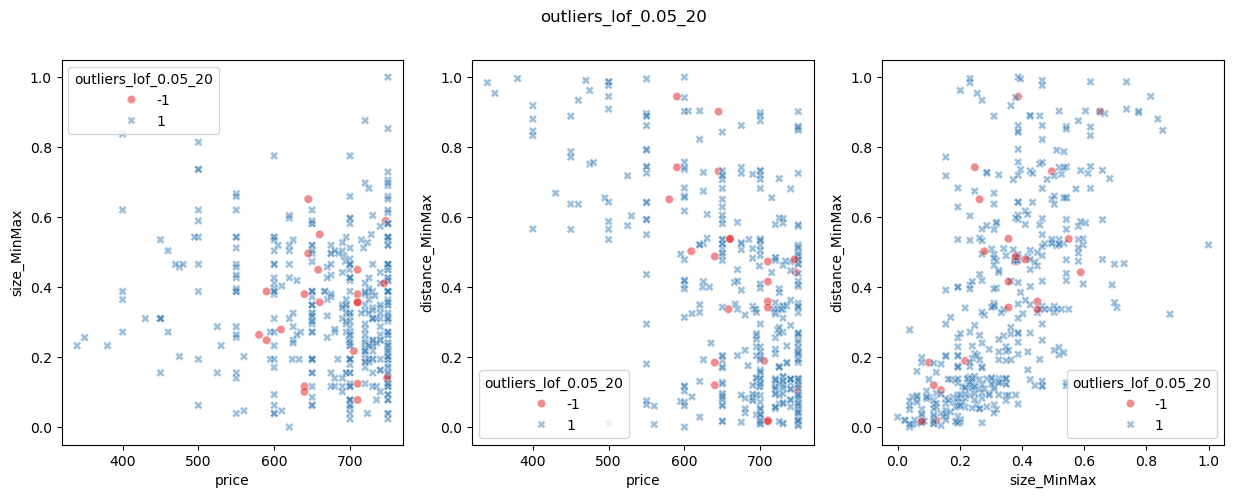

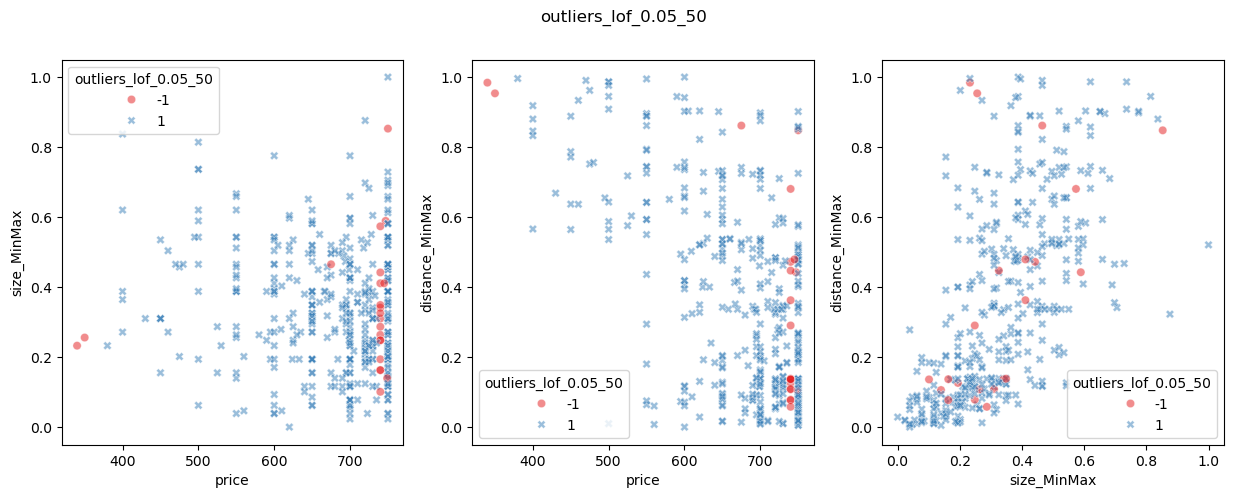

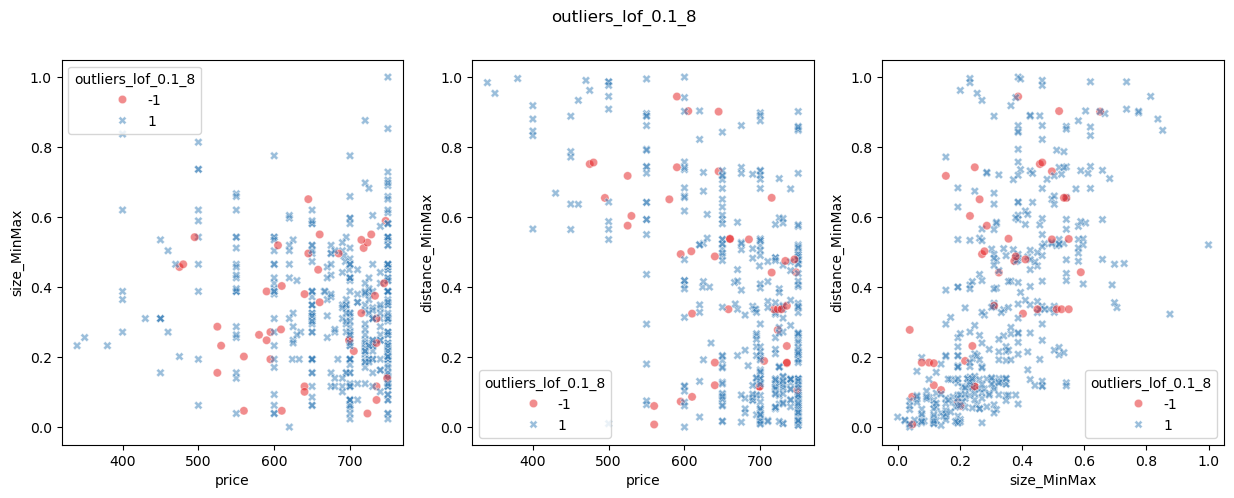

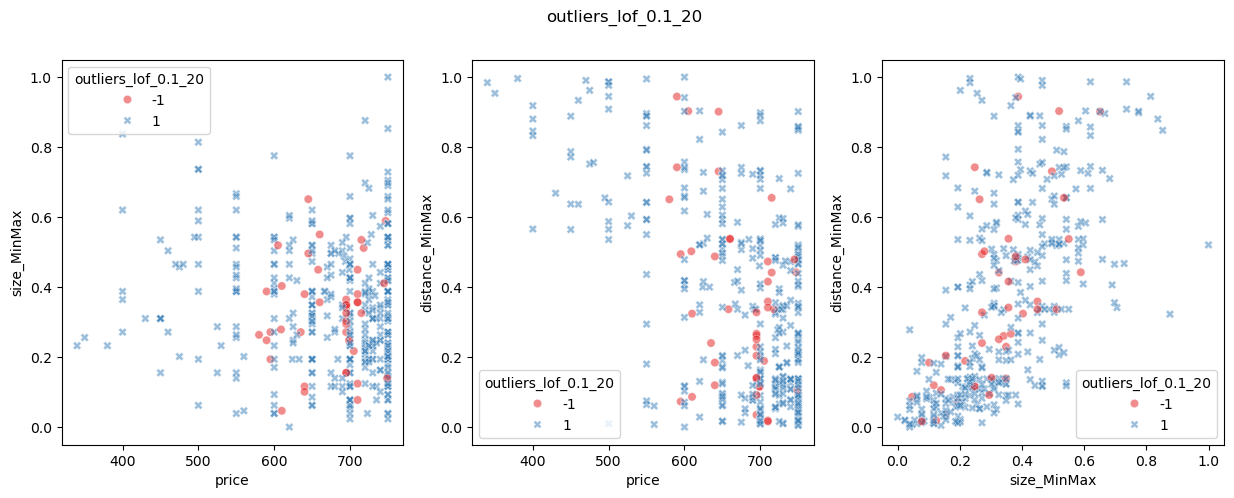

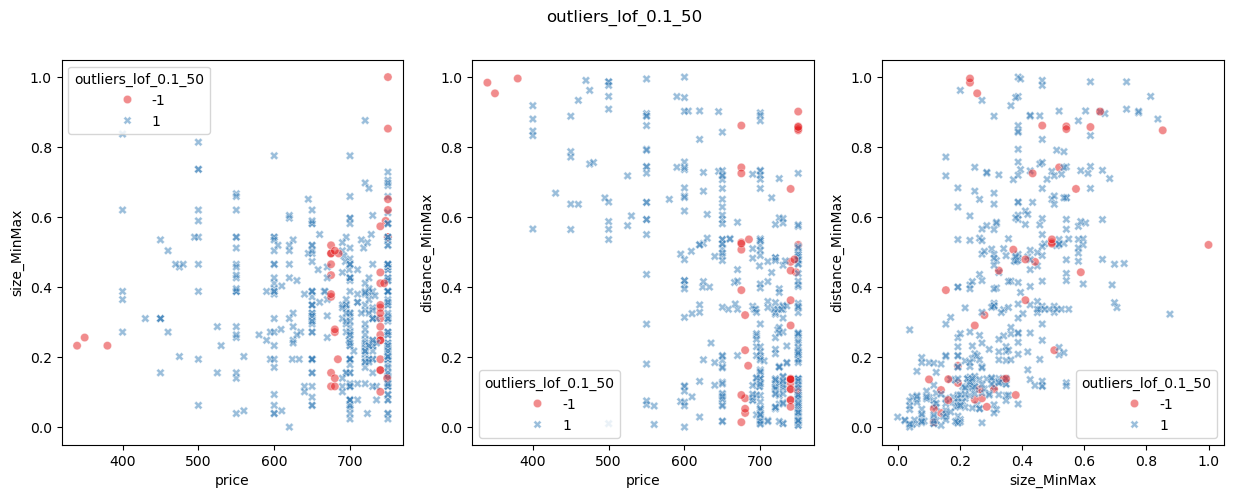

In [18]:
lista_contaminaciones = [0.01, 0.05, 0.1]
lista_neighbors = [8,20, 50]

combinaciones = list(product(lista_contaminaciones, lista_neighbors))
combinaciones


for cont, neighbors in tqdm(combinaciones):
    lof = LocalOutlierFactor(n_neighbors=neighbors,
                            contamination=cont,
                            n_jobs=-1)

    df_min[f"outliers_lof_{cont}_{neighbors}"] = lof.fit_predict(df_min[["price","size_MinMax","distance_MinMax"]])
    y_pred = lof.fit_predict(df_min[["price","size_MinMax","distance_MinMax"]])
df_min

#visualizacion
columnas_hue = df_min.filter(like="outlier").columns

combinaciones_viz = list(combinations(["price","size_MinMax","distance_MinMax"], 2))
combinaciones_viz

for outlier in tqdm(columnas_hue):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_viz):
        sns.scatterplot(x = tupla[0],
                        y = tupla[1],
                        ax = axes[indice],
                        data = df_min,
                        hue=outlier,
                        palette="Set1",
                        style=outlier,
                        alpha=0.5)
        
    plt.suptitle(outlier)

Lo que saco en claro es que el nivel de contaminación más estricto (10%) es la mejor opción porque es el que más se acerca a la realidad de los datos.  

Tras observar los gráficos del LOF observo que en el caso del tamaño, se consideran outliers aquellas viviendas que cuentan con un alto precio y según van aumentando su tamaño se va reduciendo el número de outliers. Por otro lado, al  observar la distancia nos percatamos de que de nuevo los outliers se concentran en los precios más altos lo que en un principio parece no tener sentido pues se mantienen aproximadamente igual distribuidos a lo largo de las distintas distancias. Sin embargo, no nos podemos fiar porque puede que esos datos sean outliers por otras variables que no sea la distancia.

Por el momento, me parece más adecuado hacer uso de la metodología IFO.


In [19]:
df_min.head()

price propertyType  exterior rooms bathrooms province  \
0  750.0         flat      True     1         1   Madrid   
1  750.0         flat      True     2         1   Madrid   
2  400.0    penthouse      True     2         2   Madrid   
3  450.0         flat     False     2         1  Afueras   
4  450.0         flat      True     2         1  Afueras   

                 municipality status newDevelopment floor       district  \
0                      Madrid   good          False     3      Hortaleza   
1  San Sebastián de los Reyes   good          False    bj  Centro Urbano   
2       Villamanrique de Tajo   good          False     2    desconocido   
3                       Recas   good          False     2    desconocido   
4         Cedillo del Condado   good          False     1    desconocido   

  hasLift parkingSpace  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
0    True  desconocido     0.310078         0.114738                      1   
1   False  desconocido     0.387597         0.267209                      1   
2   False  desconocido     0.364341         0.918341                      1   
3    True         True     0.534884         0.786845                      1   
4   False  desconocido     0.310078         0.637036                      1   

   outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
0                      1                       1                       1   
1                      1                       1                       1   
2                      1                       1                       1   
3                      1                       1                       1   
4                      1                       1                       1   

   outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
0                       1                     1                     1   
1                       1                     1                     1   
2                      -1                    -1                    -1   
3                       1                    -1                    -1   
4                       1                    -1                     1   

   outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  outliers_lof_0.01_8  \
0                      1                      1                    1   
1                      1                      1                    1   
2                     -1                     -1                    1   
3                     -1                     -1                    1   
4                      1                      1                    1   

   outliers_lof_0.01_20  outliers_lof_0.01_50  outliers_lof_0.05_8  \
0                     1                     1                    1   
1                     1                     1                    1   
2                     1                     1                    1   
3                     1                     1                    1   
4                     1                     1                    1   

   outliers_lof_0.05_20  outliers_lof_0.05_50  outliers_lof_0.1_8  \
0                     1                     1                   1   
1                     1                     1                   1   
2                     1                     1                   1   
3                     1                     1                   1   
4                     1                     1                   1   

   outliers_lof_0.1_20  outliers_lof_0.1_50  
0                    1                    1  
1 

In [20]:
df_min.columns

Index(['price', 'propertyType', 'exterior', 'rooms', 'bathrooms', 'province',
       'municipality', 'status', 'newDevelopment', 'floor', 'district',
       'hasLift', 'parkingSpace', 'size_MinMax', 'distance_MinMax',
       'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000', 'outliers_lof_0.01_8', 'outliers_lof_0.01_20',
       'outliers_lof_0.01_50', 'outliers_lof_0.05_8', 'outliers_lof_0.05_20',
       'outliers_lof_0.05_50', 'outliers_lof_0.1_8', 'outliers_lof_0.1_20',
       'outliers_lof_0.1_50'],
      dtype='object')

In [21]:
df_ifo=df_min[['price', 'propertyType', 'exterior', 'rooms', 'bathrooms', 'province',
       'municipality', 'status', 'newDevelopment', 'floor', 'district',
       'hasLift', 'parkingSpace', 'size_MinMax', 'distance_MinMax',
       'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000']]

In [22]:
df_ifo.head()

price propertyType  exterior rooms bathrooms province  \
0  750.0         flat      True     1         1   Madrid   
1  750.0         flat      True     2         1   Madrid   
2  400.0    penthouse      True     2         2   Madrid   
3  450.0         flat     False     2         1  Afueras   
4  450.0         flat      True     2         1  Afueras   

                 municipality status newDevelopment floor       district  \
0                      Madrid   good          False     3      Hortaleza   
1  San Sebastián de los Reyes   good          False    bj  Centro Urbano   
2       Villamanrique de Tajo   good          False     2    desconocido   
3                       Recas   good          False     2    desconocido   
4         Cedillo del Condado   good          False     1    desconocido   

  hasLift parkingSpace  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
0    True  desconocido     0.310078         0.114738                      1   
1   False  desconocido     0.387597         0.267209                      1   
2   False  desconocido     0.364341         0.918341                      1   
3    True         True     0.534884         0.786845                      1   
4   False  desconocido     0.310078         0.637036                      1   

   outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
0                      1                       1                       1   
1                      1                       1                       1   
2                      1                       1                       1   
3                      1                       1                       1   
4                      1                       1                       1   

   outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
0                       1                     1                     1   
1                       1                     1                     1   
2                      -1                    -1                    -1   
3                       1                    -1                    -1   
4                       1                    -1                     1   

   outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
0                      1                      1  
1                      1                      1  
2                     -1                     -1  
3                     -1                     -1  
4                      1                      1

Ahora me quito las que tengan todas las filas con 1 y así me quedo con todas las que al menos tienen un Outlier

In [23]:
columnasdf=df_min.filter(like="outliers_ifo")
columnas_ifo=columnasdf.columns

In [24]:

filtered_df = df_ifo[(df_ifo[columnas_ifo] == -1).all(axis=1)]

In [25]:
filtered_df

price propertyType  exterior rooms bathrooms province  \
297  340.0         flat      True     1         1  Afueras   
330  350.0         flat      True     1         1  Afueras   
331  400.0         flat     False     4         2  Afueras   
349  380.0    penthouse      True     1         1  Afueras   

                  municipality status newDevelopment floor     district  \
297                 Fuensalida   good          False     1  desconocido   
330      Las Navas del Marqués   good          False     1  desconocido   
331      Villaseca de la Sagra   good          False     4  desconocido   
349  San Ildefonso o la Granja   good          False     5  desconocido   

    hasLift parkingSpace  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
297   False         True     0.232558         0.984097                     -1   
330    True  desconocido     0.255814         0.953546                     -1   
331    True  desconocido     0.837209         0.880089                     -1   
349   False  desconocido     0.232558         0.995899                     -1   

     outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
297                     -1                      -1                      -1   
330                     -1                      -1                      -1   
331                     -1                      -1                      -1   
349                     -1                      -1                      -1   

     outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
297                     -1                     -1                      -1   
330                     -1                     -1                      -1   
331                     -1                     -1                      -1   
349                     -1                     -1                      -1   

     outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
297                      -1                    -1                    -1   
330                      -1                    -1                    -1   
331                      -1                    -1                    -1   
349                      -1                    -1                    -1   

     outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
297                     -1                     -1  
330                     -1                     -1  
331                     -1                     -1  
349                     -1                     -1

In [26]:
filtered_df.shape

(4, 27)

Al observar las filas que tienen todos los valores con -1 y observar que suponen una parte ínfima de los datos, se decide eliminarlos

In [27]:
df_result = df_ifo.drop(index = filtered_df.index)

In [28]:
df_result.reset_index(drop=True, inplace=True)

In [29]:
df_result.shape

(424, 27)

Ahora seleccionamos el 60% de los outliers

In [30]:
proporcion = 0.6 * len(columnas_ifo)
df_outliers_60 = df_result[df_result[columnas_ifo].eq(-1).sum(axis=1) >= proporcion]


In [31]:
df_ifo.shape

(428, 27)

In [32]:
df_outliers_60.shape

(15, 27)

Observamos la distancia

In [33]:
df_outliers_60["distance_MinMax"].shape

(15,)

In [34]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0.9]["distance_MinMax"]

2      0.918341
26     0.908313
215    0.986206
325    0.944774
338    0.962016
339    0.986390
Name: distance_MinMax, dtype: float64

In [35]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0.9]["distance_MinMax"].shape

(6,)

In [36]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0]["distance_MinMax"].unique()

array([0.9183407 , 0.84583836, 0.90831324, 0.00980983, 0.84789742,
       0.32258605, 0.5205906 , 0.00739922, 0.56595688, 0.98620597,
       0.94477367, 0.83283112, 0.9620162 , 0.98639012, 0.77156154])

Estamos observando los valores mayores a 0.9 (aproximadamente a partir de 55 kilometros del centro)

In [37]:
df_outliers_60.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2 to 410
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   15 non-null     float64
 1   propertyType            15 non-null     object 
 2   exterior                15 non-null     bool   
 3   rooms                   15 non-null     object 
 4   bathrooms               15 non-null     object 
 5   province                15 non-null     object 
 6   municipality            15 non-null     object 
 7   status                  15 non-null     object 
 8   newDevelopment          15 non-null     object 
 9   floor                   15 non-null     object 
 10  district                15 non-null     object 
 11  hasLift                 15 non-null     object 
 12  parkingSpace            15 non-null     object 
 13  size_MinMax             15 non-null     float64
 14  distance_MinMax         15 non-null     float64


In [38]:
df_outliers_60["distance_MinMax"].min()

0.0073992232489621

In [39]:
df_outliers_60["distance_MinMax"].max()

0.9863901165126556

In [40]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0].shape

(15, 27)

In [41]:
df_outliers_60["distance_MinMax"].shape

(15,)

Aqui quiero crear el intervalo de outliers con el que me voy a quedar.  
Dado que las viviendas con un valor de distancia mayor a 0.9 (unos 55km aproximadamente del centro) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [42]:
df_outliers_60=df_outliers_60[(df_outliers_60["distance_MinMax"] > 0 ) & (df_outliers_60["distance_MinMax"] < 0.9)]

Casi la mitad de otliers se encuentra entre 0.9 y 1 (55 y 60 kilometros de distancia aproximadamente). Esto muestra que hay otra mitad de viviendas (outliers) entre los 0 km y los 55 km aproximadamente cosa que tiene sentido con lo que no puedo eliminar estos outliers.El resto si que no tiene sentido mantenerlos (>0.9)

Ahora observamos los tamaños

In [43]:
df_outliers_60["size_MinMax"].shape

(9,)

In [44]:
df_outliers_60["size_MinMax"].unique()

array([0.3875969 , 0.0620155 , 0.85271318, 0.87596899, 1.        ,
       0.04651163, 0.27131783, 0.62015504, 0.15503876])


En los outliers de size: media(0.47) y mediana (0.39) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:1 o 0.85271318)  
En los outliers de distance: media(0.52) y mediana (0.57) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:0.00739922 o 0.00980983)  

In [45]:
pd.options.display.float_format = "{:,.2f}".format 
df_outliers_60.describe().T

count   mean    std    min    25%    50%    75%    max
price                    9.00 547.78 153.69 400.00 400.00 500.00 720.00 750.00
size_MinMax              9.00   0.47   0.37   0.05   0.16   0.39   0.85   1.00
distance_MinMax          9.00   0.52   0.34   0.01   0.32   0.57   0.83   0.85
outliers_ifo_0.01_100    9.00   0.78   0.67  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_400    9.00   1.00   0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_1000   9.00   1.00   0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_2000   9.00   0.78   0.67  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_100    9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.05_400    9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.05_1000   9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.05_2000   9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_100     9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_400     9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_1000    9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_2000    9.00  -1.00   0.00  -1.00  -1.00  -1.00  -1.00  -1.00

In [46]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.35]["size_MinMax"].unique()

array([0.0620155 , 0.04651163, 0.27131783, 0.15503876])

In [47]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.35].shape

(4, 27)

In [48]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.35]

price propertyType  exterior rooms bathrooms province  \
58  500.00       studio     False     0         1   Madrid   
165 560.00         flat     False     1         1   Madrid   
214 400.00         flat      True     1         1  Afueras   
410 450.00         flat      True     1         1   Madrid   

           municipality status newDevelopment floor     district hasLift  \
58               Madrid   good          False     1       Centro   False   
165              Madrid   good          False    bj       Centro   False   
214               Yeles   good          False     1  desconocido    True   
410  Robledo de Chavela   good          False     1  desconocido   False   

    parkingSpace  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
58   desconocido         0.06             0.01                      1   
165  desconocido         0.05             0.01                      1   
214  desconocido         0.27             0.57                     -1   
410  desconocido         0.16             0.77                      1   

     outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
58                       1                       1                       1   
165                      1                       1                       1   
214                      1                       1                       1   
410                      1                       1                       1   

     outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
58                      -1                     -1                      -1   
165                     -1                     -1                      -1   
214                     -1                     -1                      -1   
410                     -1                     -1                      -1   

     outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
58                       -1                    -1                    -1   
165                      -1                    -1                    -1   
214                      -1                    -1                    -1   
410                      -1                    -1                    -1   

     outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
58                      -1                     -1  
165                     -1                     -1  
214                     -1                     -1  
410                     -1                     -1

In [49]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.35].shape

(5, 27)

In [50]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.35]

price propertyType  exterior rooms bathrooms province  \
17  400.00    penthouse      True     2         1  Afueras   
62  750.00       chalet     False     4         1  Afueras   
68  720.00         flat     False     3         2   Madrid   
114 750.00         flat      True     2         2  Afueras   
326 400.00         flat      True     3         2  Afueras   

            municipality status newDevelopment        floor  \
17              Camarena   good          False            2   
62            Marchamalo   good          False  desconocido   
68                 Pinto   good          False            1   
114             Illescas   good          False           bj   
326  Cabañas de la Sagra   good          False            2   

                    district      hasLift parkingSpace  size_MinMax  \
17               desconocido         True  desconocido         0.39   
62               desconocido  desconocido  desconocido         0.85   
68   San José - Buenos Aires         True         True         0.88   
114      Señorío de Illescas        False         True         1.00   
326              desconocido         True         True         0.62   

     distance_MinMax  outliers_ifo_0.01_100  outliers_ifo_0.01_400  \
17              0.85                      1                      1   
62              0.85                      1                      1   
68              0.32                      1                      1   
114             0.52                      1                      1   
326             0.83                      1                      1   

     outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  outliers_ifo_0.05_100  \
17                        1                       1                     -1   
62                        1                      -1                     -1   
68                        1                       1                     -1   
114                       1                       1                     -1   
326                       1                       1                     -1   

     outliers_ifo_0.05_400  outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  \
17                      -1                      -1                      -1   
62                      -1                      -1                      -1   
68                      -1                      -1                      -1   
114                     -1                      -1                      -1   
326                     -1                      -1                      -1   

     outliers_ifo_0.1_100  outliers_ifo_0.1_400  outliers_ifo_0.1_1000  \
17                     -1                    -1                     -1   
62                     -1                    -1                     -1   
68                     -1                    -1                     -1   
114                    -1                    -1                     -1   
326                    -1                    -1                     -1   

     outliers_ifo_0.1_2000  
17                      -1  
62                      -1  
68                      -1  
114                     -1  
326                     -1

Aqui quiero crear el intervalo de outliers con el que me voy a quedar de size  
Dado que las viviendas con un valor de size menor a 0.35 (75 metros cuadrados aproximadamente) y mayor a 0.84 (135 metros cuadrados aproximadamente) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [51]:
df_outliers_60=df_outliers_60[(df_outliers_60["size_MinMax"] > 0.35 ) & (df_outliers_60["size_MinMax"] < 0.84)]

In [52]:
df_outliers_60.shape

(2, 27)

Ahora a que ya hemos analizado los outliers decidimos imputarlos usando KNN con lo que primero pasamos todos a nan y los meto en el dataframe completo donde voy a querer meter el imputer KNN (y probaremos con el iterative también)

In [53]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   424 non-null    float64
 1   propertyType            424 non-null    object 
 2   exterior                424 non-null    bool   
 3   rooms                   424 non-null    object 
 4   bathrooms               424 non-null    object 
 5   province                424 non-null    object 
 6   municipality            424 non-null    object 
 7   status                  424 non-null    object 
 8   newDevelopment          424 non-null    object 
 9   floor                   424 non-null    object 
 10  district                424 non-null    object 
 11  hasLift                 424 non-null    object 
 12  parkingSpace            424 non-null    object 
 13  size_MinMax             424 non-null    float64
 14  distance_MinMax         424 non-null    fl

In [54]:
df_result.loc[df_outliers_60.index, "size_MinMax"] = np.nan
df_result.loc[df_outliers_60.index, "distance_MinMax"] = np.nan

In [55]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   424 non-null    float64
 1   propertyType            424 non-null    object 
 2   exterior                424 non-null    bool   
 3   rooms                   424 non-null    object 
 4   bathrooms               424 non-null    object 
 5   province                424 non-null    object 
 6   municipality            424 non-null    object 
 7   status                  424 non-null    object 
 8   newDevelopment          424 non-null    object 
 9   floor                   424 non-null    object 
 10  district                424 non-null    object 
 11  hasLift                 424 non-null    object 
 12  parkingSpace            424 non-null    object 
 13  size_MinMax             422 non-null    float64
 14  distance_MinMax         422 non-null    fl

In [56]:
df_numericas=df_result.select_dtypes(include=np.number)
imputer_knn= KNNImputer(n_neighbors=5)   #por defecto siempre lo calcula en base a la media y no se puede cambiar
knn_imputado= imputer_knn.fit_transform(df_numericas)    #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_knn=df_result.copy()
df_num_sin_nulos=pd.DataFrame(knn_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_knn[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos


In [57]:
df_knn.isna().sum()

price                     0
propertyType              0
exterior                  0
rooms                     0
bathrooms                 0
province                  0
municipality              0
status                    0
newDevelopment            0
floor                     0
district                  0
hasLift                   0
parkingSpace              0
size_MinMax               0
distance_MinMax           0
outliers_ifo_0.01_100     0
outliers_ifo_0.01_400     0
outliers_ifo_0.01_1000    0
outliers_ifo_0.01_2000    0
outliers_ifo_0.05_100     0
outliers_ifo_0.05_400     0
outliers_ifo_0.05_1000    0
outliers_ifo_0.05_2000    0
outliers_ifo_0.1_100      0
outliers_ifo_0.1_400      0
outliers_ifo_0.1_1000     0
outliers_ifo_0.1_2000     0
dtype: int64

In [58]:
df_knn.describe().T

count   mean   std    min    25%    50%    75%    max
price                  424.00 675.42 79.60 400.00 648.75 700.00 740.00 750.00
size_MinMax            424.00   0.33  0.17   0.00   0.20   0.31   0.46   1.00
distance_MinMax        424.00   0.35  0.28   0.00   0.11   0.30   0.54   1.00
outliers_ifo_0.01_100  424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_400  424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_1000 424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_2000 424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_100  424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_400  424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_1000 424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_2000 424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_100   424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_400   424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_1000  424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_2000  424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00

In [59]:
df_knn.to_csv("../../datos/datos1/datos_sin_outliers.csv")

In [60]:
df=pd.read_csv("../../datos/datos1/datos_sin_outliers.csv", index_col=0).reset_index(drop=True)

In [61]:
df_filt=df[["price", "size_MinMax", "distance_MinMax"]]

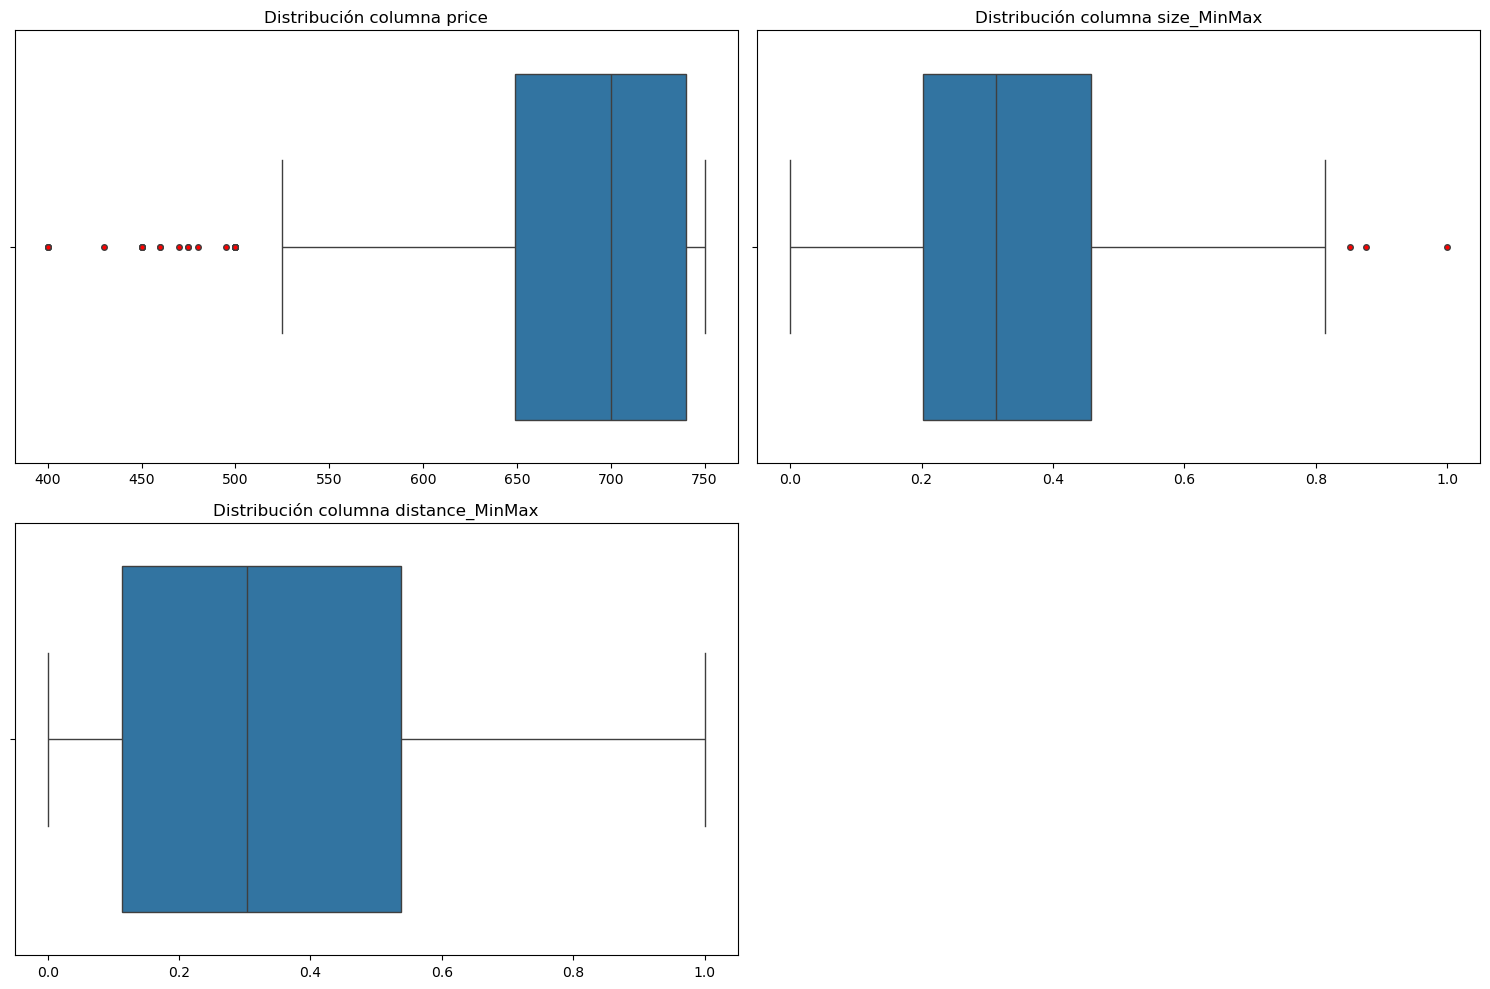

In [62]:
f.plot_outliers_univariados(df_filt, "b", (15,10))

In [63]:
df_est_con3=df_min[["price", "size_MinMax", "distance_MinMax"]]

In [64]:
(df_filt["size_MinMax"]> 0.8).sum()

4

In [65]:
(df_est_con3["size_MinMax"]> 0.8).sum()

5

In [66]:
(df_filt["price"]< 510).sum()

27

In [67]:
(df_est_con3["price"]< 510).sum()

31

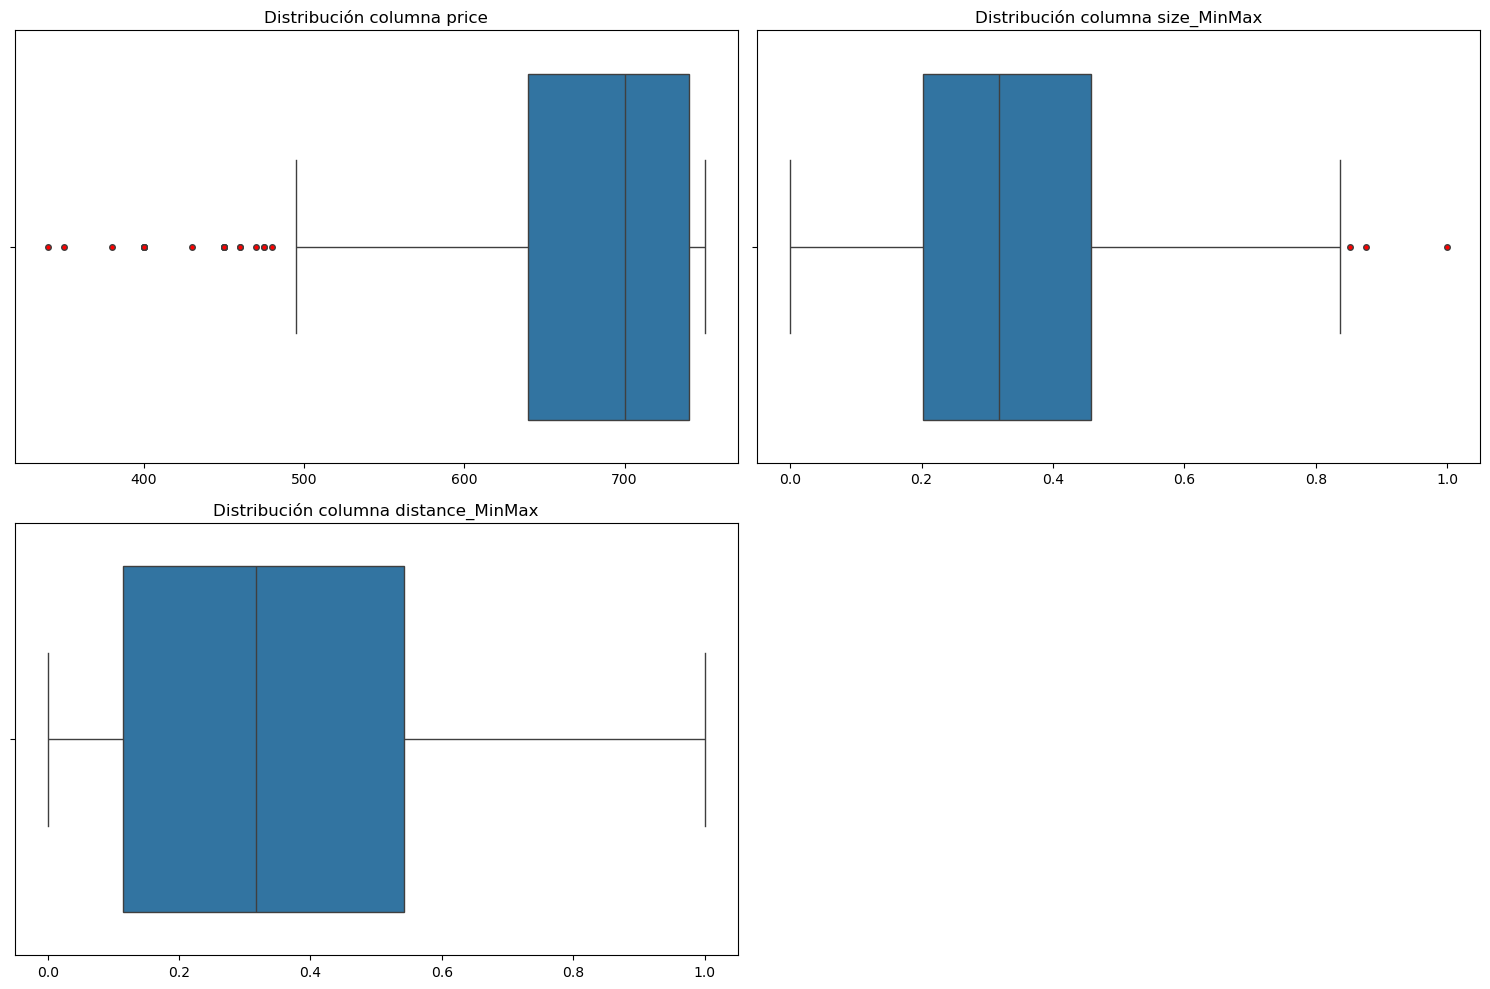

In [68]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

caso con iterative

In [69]:
df_numericas=df_result.select_dtypes(include=np.number)
df_numericas.drop(columns="price", inplace=True)
imputer_iterative= IterativeImputer()       #Aquí se puede poner el KNNImputer o el RandomForestRegressor
                                            #missing values es por si los nulos no estan como np.nan sino en texto por ejemplo (aunque lo suyo es limpiarlo en el EDA)
                                            #initial_strategy= "median" sirve para indicar que me lo haga con las medianas
iterative_imputado=imputer_iterative.fit_transform(df_numericas)   #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_iterativo=df_result.copy()
df_num_sin_nulos=pd.DataFrame(iterative_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_iterativo[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos

In [70]:
df_iterativo.isna().sum()

price                     0
propertyType              0
exterior                  0
rooms                     0
bathrooms                 0
province                  0
municipality              0
status                    0
newDevelopment            0
floor                     0
district                  0
hasLift                   0
parkingSpace              0
size_MinMax               0
distance_MinMax           0
outliers_ifo_0.01_100     0
outliers_ifo_0.01_400     0
outliers_ifo_0.01_1000    0
outliers_ifo_0.01_2000    0
outliers_ifo_0.05_100     0
outliers_ifo_0.05_400     0
outliers_ifo_0.05_1000    0
outliers_ifo_0.05_2000    0
outliers_ifo_0.1_100      0
outliers_ifo_0.1_400      0
outliers_ifo_0.1_1000     0
outliers_ifo_0.1_2000     0
dtype: int64

In [71]:
df_iterativo.describe().T

count   mean   std    min    25%    50%    75%    max
price                  424.00 675.42 79.60 400.00 648.75 700.00 740.00 750.00
size_MinMax            424.00   0.33  0.17   0.00   0.20   0.32   0.46   1.00
distance_MinMax        424.00   0.35  0.27   0.00   0.11   0.30   0.54   1.00
outliers_ifo_0.01_100  424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_400  424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_1000 424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_2000 424.00   1.00  0.10  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_100  424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_400  424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_1000 424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_2000 424.00   0.92  0.40  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_100   424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_400   424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_1000  424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_2000  424.00   0.82  0.58  -1.00   1.00   1.00   1.00   1.00

In [72]:
df_iterativo.to_csv("../../datos/datos1/datos_sin_outliers_iterativo.csv")

In [73]:
df_it=pd.read_csv("../../datos/datos1/datos_sin_outliers_iterativo.csv", index_col=0).reset_index(drop=True)

In [74]:
df_filt_it=df_it[["price", "size_MinMax", "distance_MinMax"]]

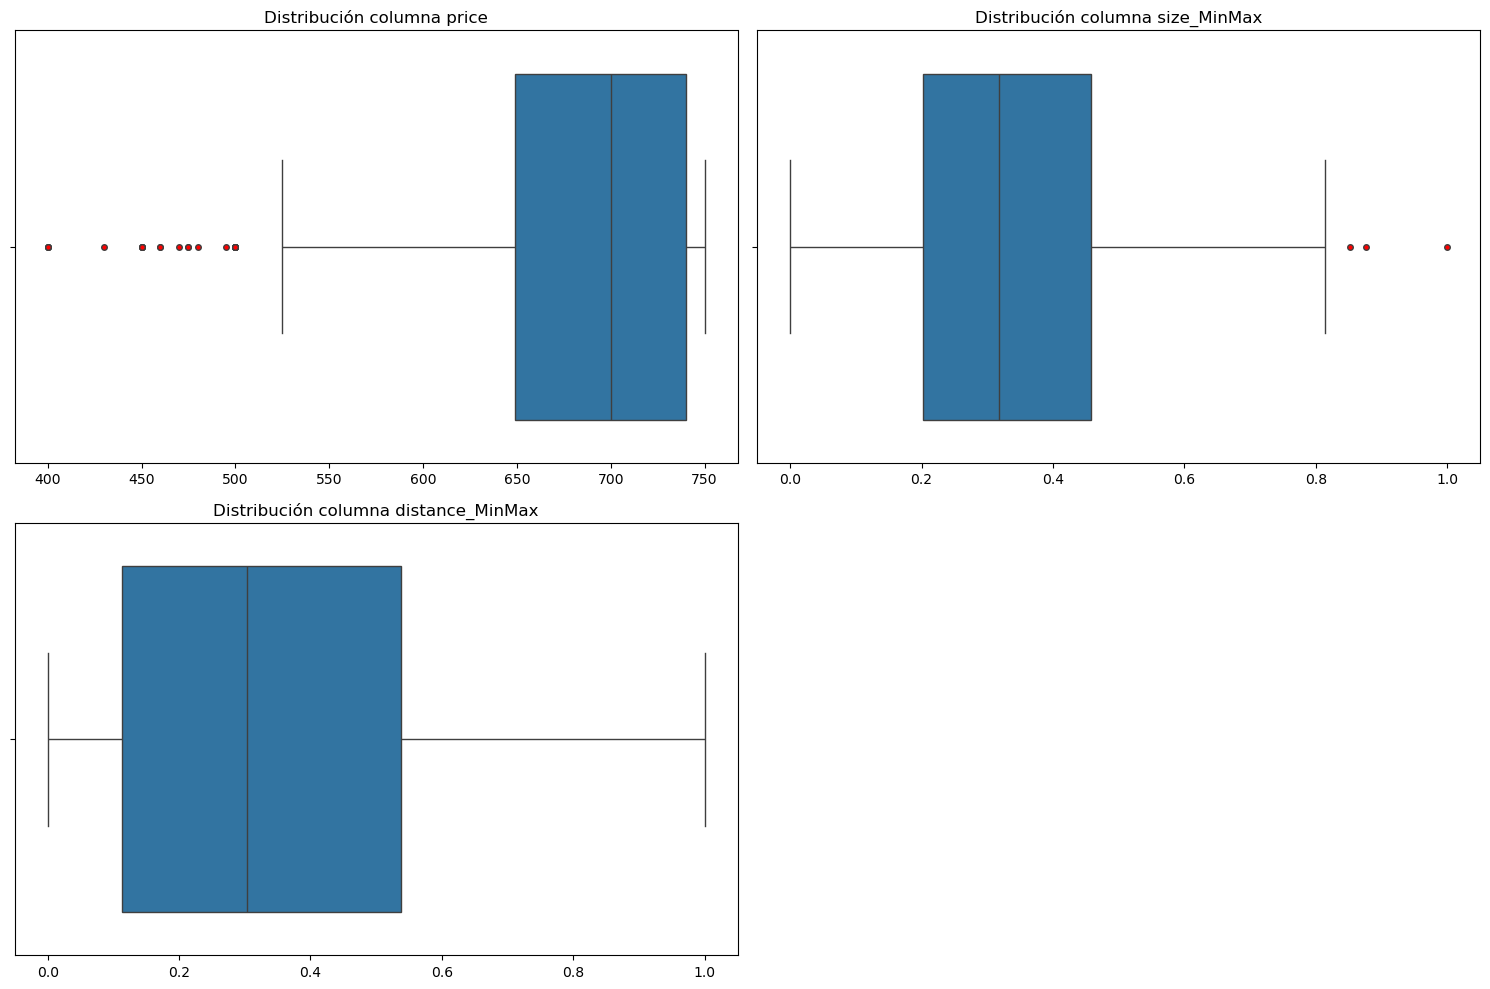

In [75]:
f.plot_outliers_univariados(df_filt_it, "b", (15,10))

In [76]:
df_est_con3=df_min[["price", "size_MinMax", "distance_MinMax"]]

In [77]:
(df_filt_it["size_MinMax"]> 0.8).sum()

4

In [78]:
(df_est_con3["size_MinMax"]> 0.8).sum()

5

In [79]:
(df_filt_it["price"]< 510).sum()

27

In [80]:
(df_est_con3["price"]< 510).sum()

31

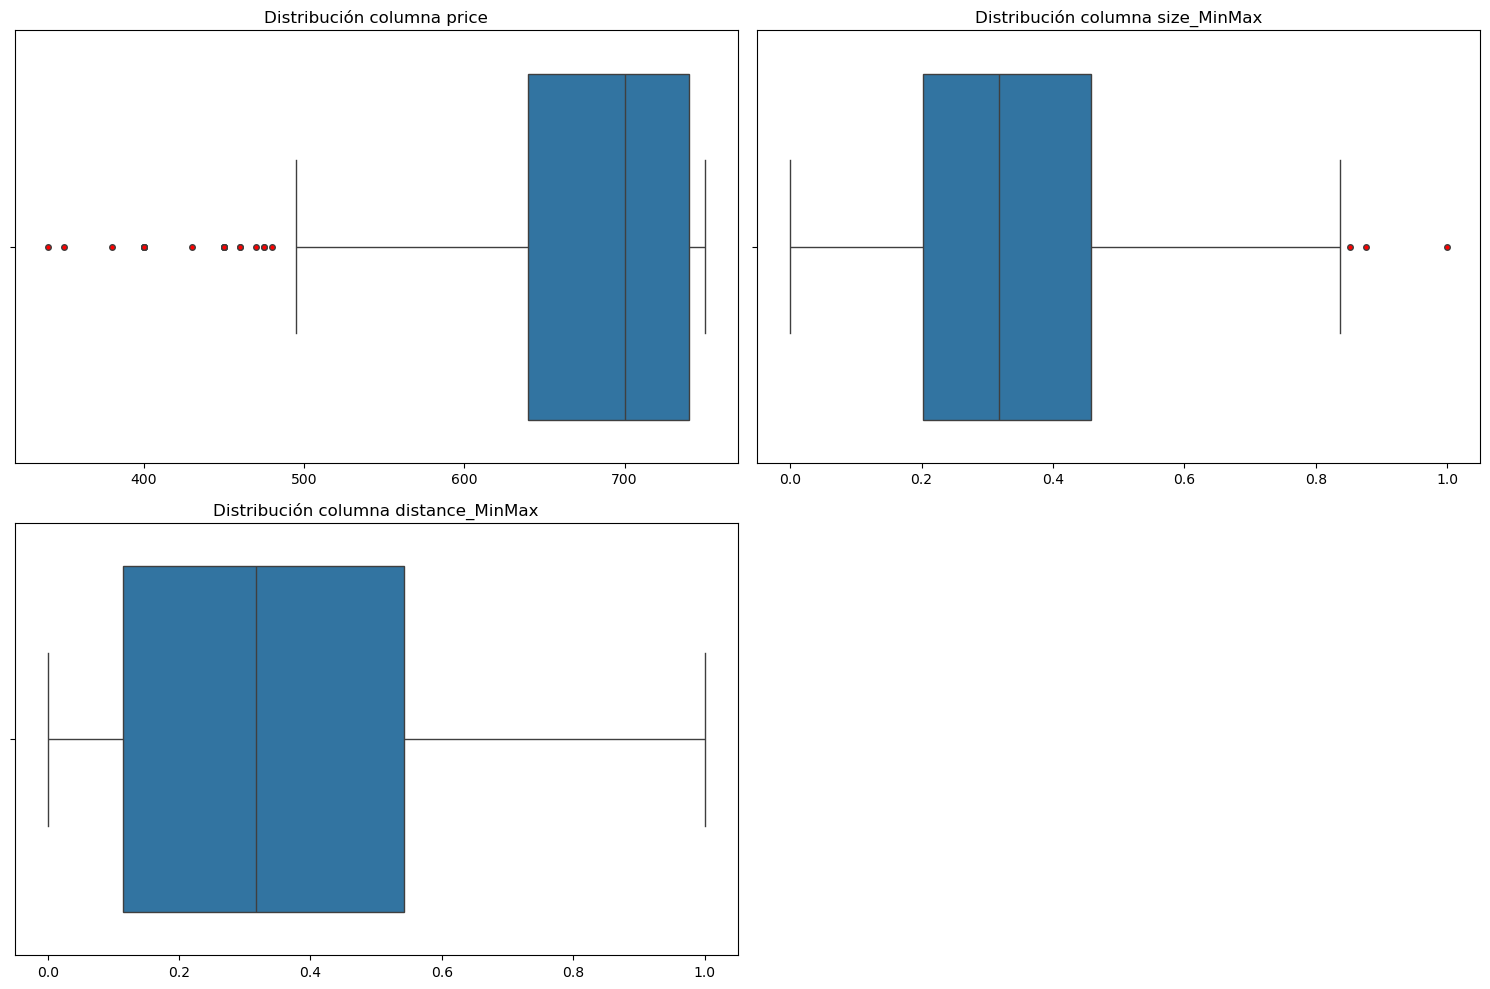

In [81]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

Ya están tratados

Observamos que no hay diferencias muy significativas entre imputar con KNN o con ITERATIVE pero tras observar que el iterative reduce la dispersión entre la media y la mediana de size y que el KNN aumenta la desviación típica (variabilidad) en la distancia, nos decantamos finalmente por el uso del ITERATIVE

**ITERATIVE:**  
***size***  
*MEDIA:* 0.33  
*MEDIANA:* 0.32  
*DESVIACIÓN:* 0.17  
  
***distance***  
*MEDIA:* 0.35  
*MEDIANA:* 0.30  
*DESVIACIÓN:* 0.27    
  
**KNN:**  
***size***  
*MEDIA:* 0.33  
*MEDIANA:* 0.31  
*DESVIACIÓN:* 0.17   

***distance***  
*MEDIA:* 0.35  
*MEDIANA:* 0.30  
*DESVIACIÓN:* 0.28     